# Stats 6545 Assignment 3 - Emmeline Williams - 201700028

In [14]:
import numpy as np
from numpy.random import normal, uniform, multivariate_normal
import matplotlib.pyplot as plt

In [15]:
def binary_prob(N,x,b):
    # Calculate p(y = 1|x)
    prob = np.zeros(N)
    lx = len(b) - 1
    for n in range(N):
        prob[n] = 1/(1+np.exp(-(b[0] + sum(b[i+1]*x[i,n] for i in range(lx)))))
    return prob

def generate_logistic(N,betas,seed=1000):
    # Generate data from logistic regression model
    np.random.seed(seed)
    lx = len(betas)-1
    x = np.zeros([lx,N])
    # Sample N vectors x from Uniform[-2,2]
    for i in range(lx):
        x[i,:] = uniform(-2,2,N)
    # Calculate p(y^n = 1|x)
    bi_prob = binary_prob(N, x, betas)
    # Sample N values of y for each x according to that probability
    y = np.zeros([N,N])
    for i in range(N):
        y[i,:] = [1 if (uniform(0,1) < bi_prob[j]) else 0 for j in range(N)]
    # Count the proportion of 0s and 1s
    _, counts = np.unique(y, return_counts=True)
    return x, y, bi_prob, counts[0], counts[1]

def alpha(x0,x1,N,datx,daty):
    # Acceptance probability
    prior_ratio = 1/2*(np.linalg.norm(x0)-np.linalg.norm(x1))
    prob_x0 = binary_prob(N, datx, x0)
    l_x0 = sum([daty[0,i]*np.log(prob_x0[i]) + (1-daty[0,i])*np.log(1-prob_x0[i]) for i in range(N)])
    prob_x1 = binary_prob(N, datx, x1)
    l_x1 = sum([daty[0,i]*np.log(prob_x1[i]) + (1-daty[0,i])*np.log(1-prob_x1[i]) for i in range(N)])
    like_ratio = l_x1 - l_x0
    return np.min([0,prior_ratio + like_ratio])

In [74]:
def MH_walk(x0,c,dof,N,its,datx,daty):
    # Metropolis-Hastings random walk
    points = np.zeros([dof,its])
    accepted = np.zeros(its)
    GR = np.zeros([dof,its])
    for i in range(its):
        ϵ = multivariate_normal(np.zeros(dof),c*np.identity(dof))
        x1 = x0 + ϵ
        α = alpha(x0,x1,N,datx,daty)
        u = uniform(0,1)
        if u <= np.exp(α):
            x0 = x1
            accepted[i] = 1
        points[:,i] = x0
    chain_mean = np.mean(points,axis=1)
    GR[:,0] = (points[:,0]-chain_mean)**2
    for i in range(1,its):
        GR[:,i] = GR[:,i-1] + (points[:,i]-chain_mean)**2
    return points, accepted, chain_mean, GR

def MH_walk_two_proposals(x0,dof,N,its,datx,daty):
    # Metropolis-Hastings with two proposals
    points = np.zeros([dof,its])
    accepted = np.zeros(its)
    GR = np.zeros([dof,its])
    for i in range(its):
        if uniform(0,1) <= 0.5:
            if N == 200:
                ϵ = multivariate_normal(np.zeros(dof),0.074*np.identity(dof)) # 10% acceptance
            else:
                ϵ = multivariate_normal(np.zeros(dof),0.015*np.identity(dof)) # 10% acceptance
        else:
            if N == 200:
                ϵ = multivariate_normal(np.zeros(dof),0.022*np.identity(dof)) # 30% acceptance
            else:
                ϵ = multivariate_normal(np.zeros(dof),0.003*np.identity(dof)) # 30% acceptance
        x1 = x0 + ϵ
        α = alpha(x0,x1,N,datx,daty)
        u = uniform(0,1)
        if u <= np.exp(α):
            x0 = x1
            accepted[i] = 1
        points[:,i] = x0
    chain_mean = np.mean(points,axis=1)
    GR[:,0] = (points[:,0]-chain_mean)**2
    for i in range(1,its):
        GR[:,i] = GR[:,i-1] + (points[:,i]-chain_mean)**2
    return points, accepted, chain_mean, GR

def MH_walk_Gibbs(x0,c,dof,N,its,datx,daty):
    # Metropolis-within-Gibbs
    points = np.zeros([dof,its])
    accepted = np.zeros([dof,its])
    GR = np.zeros([dof,its])
    for i in range(its):
        # i iterates in time
        x_old = x0.copy()
        for j in range(dof):
            # update each parameter once per Gibbs cycle using MH
            x1 = x0.copy()
            x1[j] += normal(0,c[j])
            α = alpha(x_old,x1,N,datx,daty)
            u = uniform(0,1)
            if u <= np.exp(α):
                x0 = x1
                accepted[j,i] = 1
        points[:,i] = x0
    chain_mean = np.mean(points,axis=1)
    GR[:,0] = (points[:,0]-chain_mean)**2
    for i in range(1,its):
        GR[:,i] = GR[:,i-1] + (points[:,i]-chain_mean)**2
    return points, accepted, chain_mean, GR

def main_walker(N=200,dof=3,c=0.03,M=20,burn_ind=100,Gibbs=False,two_proposal=False):
    np.random.seed(10000)
    its = 500
    beta0 = np.zeros(dof)
    beta0[0:3] = [0.1,1.1,-0.9]
    if dof > 3:
        beta0[3:] = uniform(-1,1,dof-3)
    print(f'True value of β: {np.round(beta0,4)}')
    datx, daty, bi_prob, _, _ = generate_logistic(N,beta0,seed=5000) #Initial data
    
    x = np.linspace(0,its,its)
    GR_running = np.zeros([dof,its])
    cmeans = np.zeros([dof,M])
    if Gibbs:
        arate = np.zeros(dof)
    else:
        arate = 0
    plt.figure(figsize=(14,10*int(dof/3)))
    for i in range(M):
        x0 = normal(0,1,dof)
        if two_proposal:
            p, acc, cmean, GR_r = MH_walk_two_proposals(x0,dof,N,its,datx,daty)
        elif Gibbs:
            p, acc, cmean, GR_r = MH_walk_Gibbs(x0,c,dof,N,its,datx,daty)
        else:
            p, acc, cmean, GR_r = MH_walk(x0,c,dof,N,its,datx,daty)
        if i == 0:
            p_all = p[:,burn_ind:]
        else:
            p_all = np.hstack([p_all[:,burn_ind:],p[:,burn_ind:]])
        GR_running += GR_r
        cmeans[:,i] = cmean
        if not Gibbs:
            arate += 100*sum(acc[:])/len(acc[:])
        for j in range(dof):
            if Gibbs:
                arate[j] += 100*sum(acc[j,:])/len(acc[j,:])
            plt.subplot(dof,2,2*j+1)
            plt.plot(x,p[j,:])
        print(f'Chain {i+1} done')
    print('--------------------------------------------------------')
    print(f'Average acceptance rate {np.round(arate/M,3)}')
    for i in range(dof):
        plt.subplot(dof,2,2*i+1)
        plt.axhline(beta0[i],color='black',ls='--')
        plt.axvline(burn_ind,color='black',ls='--')
        plt.title(f'Trace plots for β{i}')
    if M == 1:
        B = np.zeros(dof)
    else:
        B = sum([(cmeans[:,i]-np.mean(cmeans,axis=1))**2 for i in range(M)])/(M-1)
    W = GR_running/((its-1)*M)
    V = np.add((1-1/its)*W,B[:,None])
    print(f'Parameters found: {np.round(np.mean(cmeans,axis=1),3)}')
    for i in range(dof):
        dat = p_all[i,:]
        m = np.mean(dat)
        plt.subplot(dof,2,2*(i+1))
        plt.hist(dat,bins=15)
        plt.axvline(beta0[i],color='black',ls='--',label='True value')
        plt.axvline(m,color='red',ls='--',label='Post mean')
        plt.title(f'Histogram for β{i}')
        plt.legend()
        err = np.abs(m-beta0[i])/np.std(dat)
        print(f"""β{i} - True mean: {np.round(beta0[i],3)} | Posterior mean: {
                np.round(m,3)} | Posterior standard deviation σ: {
                np.round(np.std(dat),3)} | Difference: {np.round(err,3)}σ""")
    plt.tight_layout(pad=2)
    plt.show()

    if M > 1:
        plt.figure(figsize=(14,6))
        plt.subplot(2,2,1)
        for i in range(dof):
            plt.plot(x[:],np.sqrt(V/W).T[:,i],label=f'β{i}')
        plt.axvline(burn_ind,color='black',ls='--')
        plt.title('Gelman-Rubin statistic (on 0 <= t <= 500)')
        plt.xlabel('t')
        plt.legend(loc='upper right')
        
        plt.subplot(2,2,2)
        for i in range(dof):
            plt.plot(x[:],np.gradient(np.sqrt(V/W).T[:,i]),label=f'β{i}')
        plt.axvline(burn_ind,color='black',ls='--')
        plt.title('Derivative of the Gelman-Rubin statistic (on 0 <= t <= 500)')
        plt.xlabel('t')
        plt.legend()
        
        plt.subplot(2,2,3)
        for i in range(dof):
            plt.plot(x[int(burn_ind/2):its-100],np.sqrt(V/W).T[int(burn_ind/2):its-100,i],label=f'β{i}')
        plt.axhline(1,color='black',ls='--')
        plt.axvline(burn_ind,color='black',ls='--')
        plt.title(f'Gelman-Rubin statistic (on {int(burn_ind/2)} <= t <= {its-100})')
        plt.xlabel('t')
        plt.legend(loc='upper right')
        
        plt.subplot(2,2,4)
        for i in range(dof):
            plt.plot(x[int(burn_ind/2):its-100],np.gradient(np.sqrt(V/W).T[int(burn_ind/2):its-100,i]),label=f'β{i}')
        plt.axhline(0,color='black',ls='--')
        plt.axvline(burn_ind,color='black',ls='--')
        plt.title(f'Derivative of the Gelman-Rubin statistic (on {int(burn_ind/2)} <= t <= {its-100})')
        plt.xlabel('t')
        plt.legend()
        plt.tight_layout(pad=2)
        plt.show()

## 1.)
For $N = 200$ pairs $(x_1,x_2)$, the proportion of zeros to ones obtained from the model is $0.49:0.51$, nearly $1:1$.

As in assignment 2, this seems reasonable, as we expect the ratio of zeros to ones to be approximately $0.52:0.48$ in the limit as $N \to \infty$.

In [4]:
betas = [0.1, 1.1, -0.9]
N = 200
datx, daty, bi_prob, c0, c1 = generate_logistic(N,betas,10)
print(f'For N = {N} proportion of zeros to ones is {round(c0/(c1+c0),2)}:{round(c1/(c1+c0),2)}')

For N = 200 proportion of zeros to ones is 0.49:0.51


## 2.)

I ran one chain of the Metropolis-Hastings random walk with 500 iterations to check its behaviour. Test runs show that a variance of $c = 0.085$ for the Gaussian proposal gives an acceptance rate of $22\%$, close to the desired $23.4\%$.

True value of β: [ 0.1  1.1 -0.9]
Chain 1 done
--------------------------------------------------------
Average acceptance rate 22.0
Parameters found: [ 0.249  0.785 -0.721]
β0 - True mean: 0.1 | Posterior mean: 0.275 | Posterior standard deviation σ: 0.154 | Difference: 1.14σ
β1 - True mean: 1.1 | Posterior mean: 0.815 | Posterior standard deviation σ: 0.187 | Difference: 1.525σ
β2 - True mean: -0.9 | Posterior mean: -0.763 | Posterior standard deviation σ: 0.176 | Difference: 0.776σ


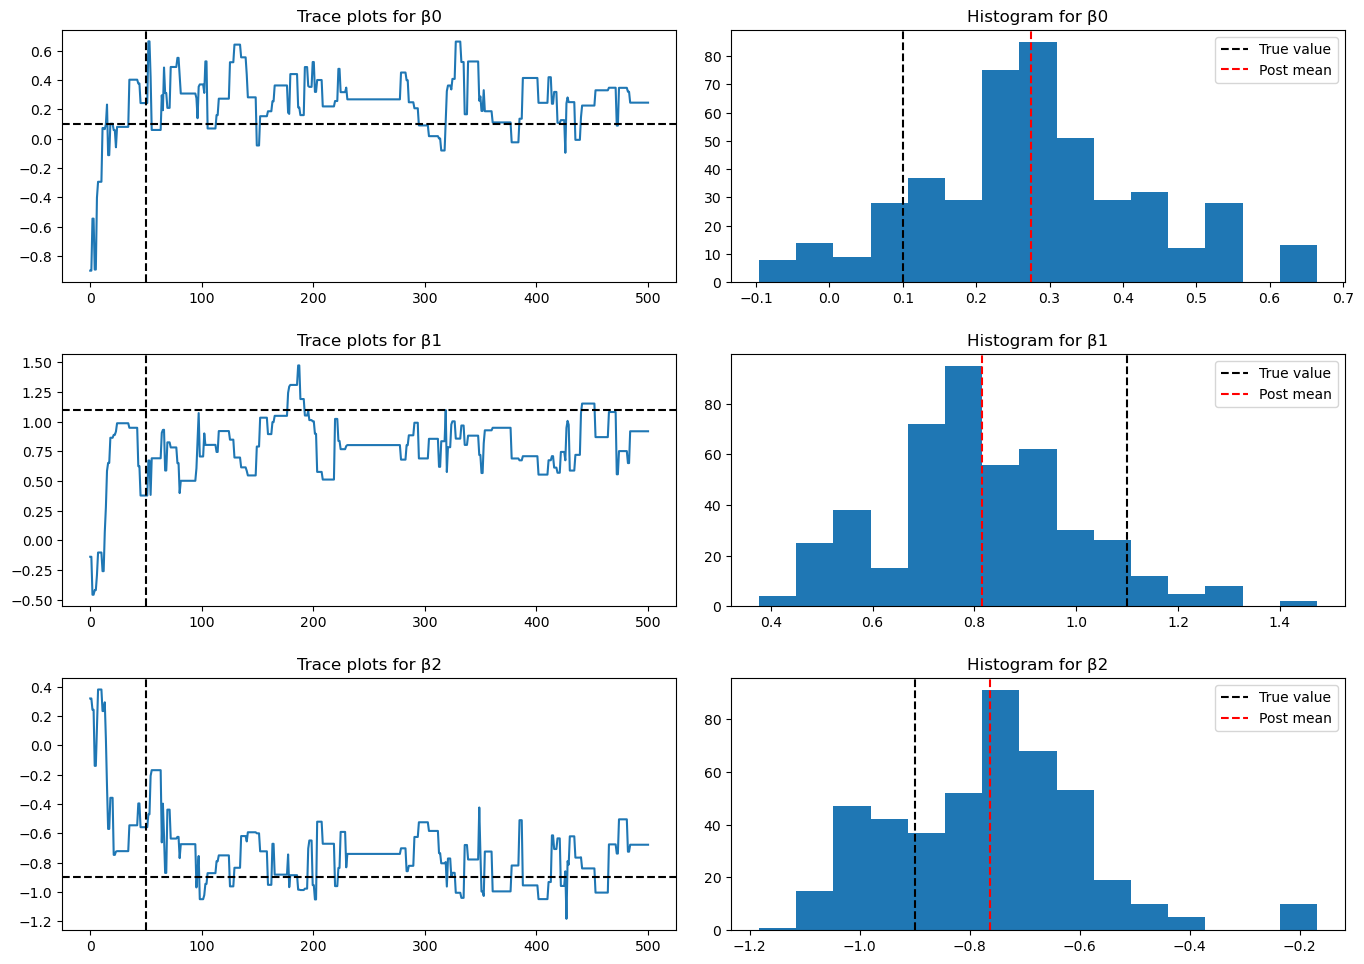

In [5]:
main_walker(N=200,dof=3,c=0.085,M=1,burn_ind=50)  ## One chain, 3 parameters, basic MH model

I increase the number of chains to $M=20$, and compare the trace plots and sample histograms. $c=0.085$ gives an acceptance rate across all chains and iterations of $23.3\%,$ and the averaged estimate of $\beta = (0.1, 1.1, -0.9)$ is $(0.294, 0.798, -0.751)$, an absolute error of $(0.194, 0.302, 0.149)$. Going off the trace plots for $N=200$, the different chains converge around the estimated value after a burn-in period of about $30$ iterations. Tracking the Gelman-Rubin statistic for each chain, as well as its derivative, shows a similar burn-in period. The statistic converges to just above $1$, showing that each chain has converged. The posterior standard deviations for each parameter are fairly large, so despite the relatively large error, the histograms encompass the true parameter values.


This estimate isn't as accurate as expected, so I checked the case with $N=2000$ iterations to see if a more concentrated posterior would improve it. The estimates do improve; for $c=0.007$, the new estimate is $(0.11, 0.974, -0.833)$ with absolute error $(0.01, 0.126, 0.067)$. This shows that the model does converge to the true value if the posterior is sufficiently concentrated, although slower than expected, which could result from an error in the code. For $N=2000$, the trace plots have a smaller range and standard deviation, but the burn-in period has increased to about $100$ iterations, matching the Gelman-Rubin statistic plots.

I also tested different values for the variance $c$ (with $N=200$) regardless of the resulting acceptance rate. I found that changing $c$ did not have much effect on the overall error; although the errors for each parameter varied with $c$, the sum of the absolute errors was approximately $0.64$ for $c$ ranging from $0.01$ to $0.5$; for example, for $c=0.5$ the error was $(0.204,0.2654,0.17)$, an improvement for $\beta_1$ but worse for $\beta_0$ and $\beta_2$. The fact that this measure is fairly constant suggests some aspect of the code is leading to a shift between the posterior means and true values as a whole; decreasing the error in one parameter increases the error in another.

True value of β: [ 0.1  1.1 -0.9]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 23.31
Parameters found: [ 0.294  0.798 -0.751]
β0 - True mean: 0.1 | Posterior mean: 0.3 | Posterior standard deviation σ: 0.163 | Difference: 1.226σ
β1 - True mean: 1.1 | Posterior mean: 0.823 | Posterior standard deviation σ: 0.169 | Difference: 1.642σ
β2 - True mean: -0.9 | Posterior mean: -0.764 | Posterior standard deviation σ: 0.164 | Difference: 0.829σ


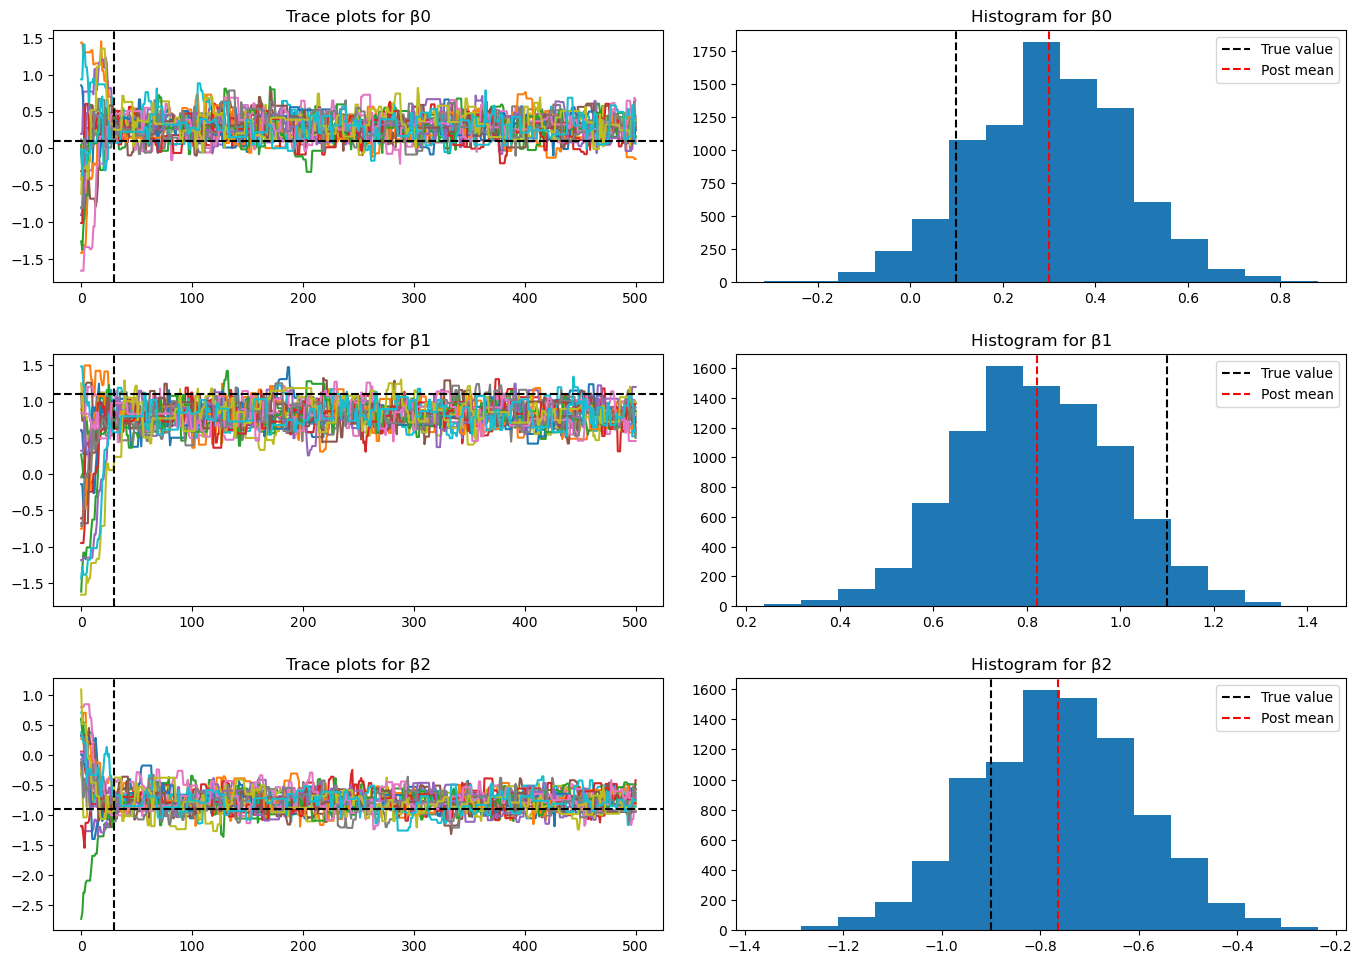

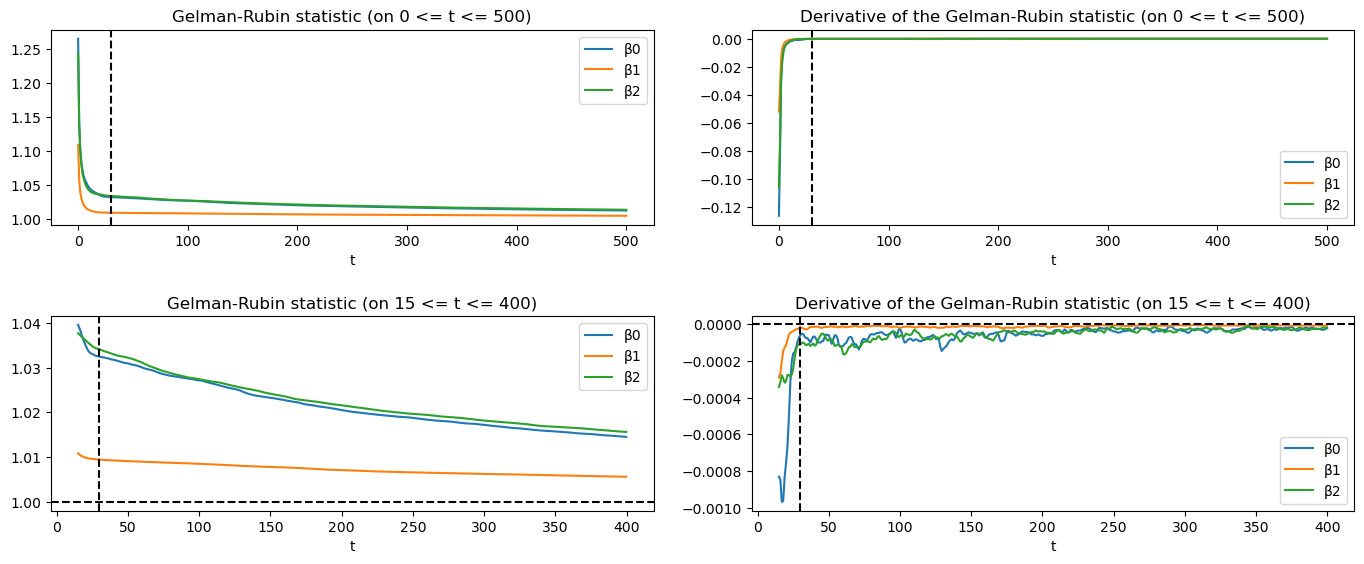

In [25]:
main_walker(N=200,dof=3,c=0.085,M=20,burn_ind=30) ## 20 chains, 3 parameters, basic MH model

True value of β: [ 0.1  1.1 -0.9]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 28.91
Parameters found: [ 0.11   0.974 -0.833]
β0 - True mean: 0.1 | Posterior mean: 0.08 | Posterior standard deviation σ: 0.055 | Difference: 0.367σ
β1 - True mean: 1.1 | Posterior mean: 1.047 | Posterior standard deviation σ: 0.056 | Difference: 0.944σ
β2 - True mean: -0.9 | Posterior mean: -0.881 | Posterior standard deviation σ: 0.058 | Difference: 0.329σ


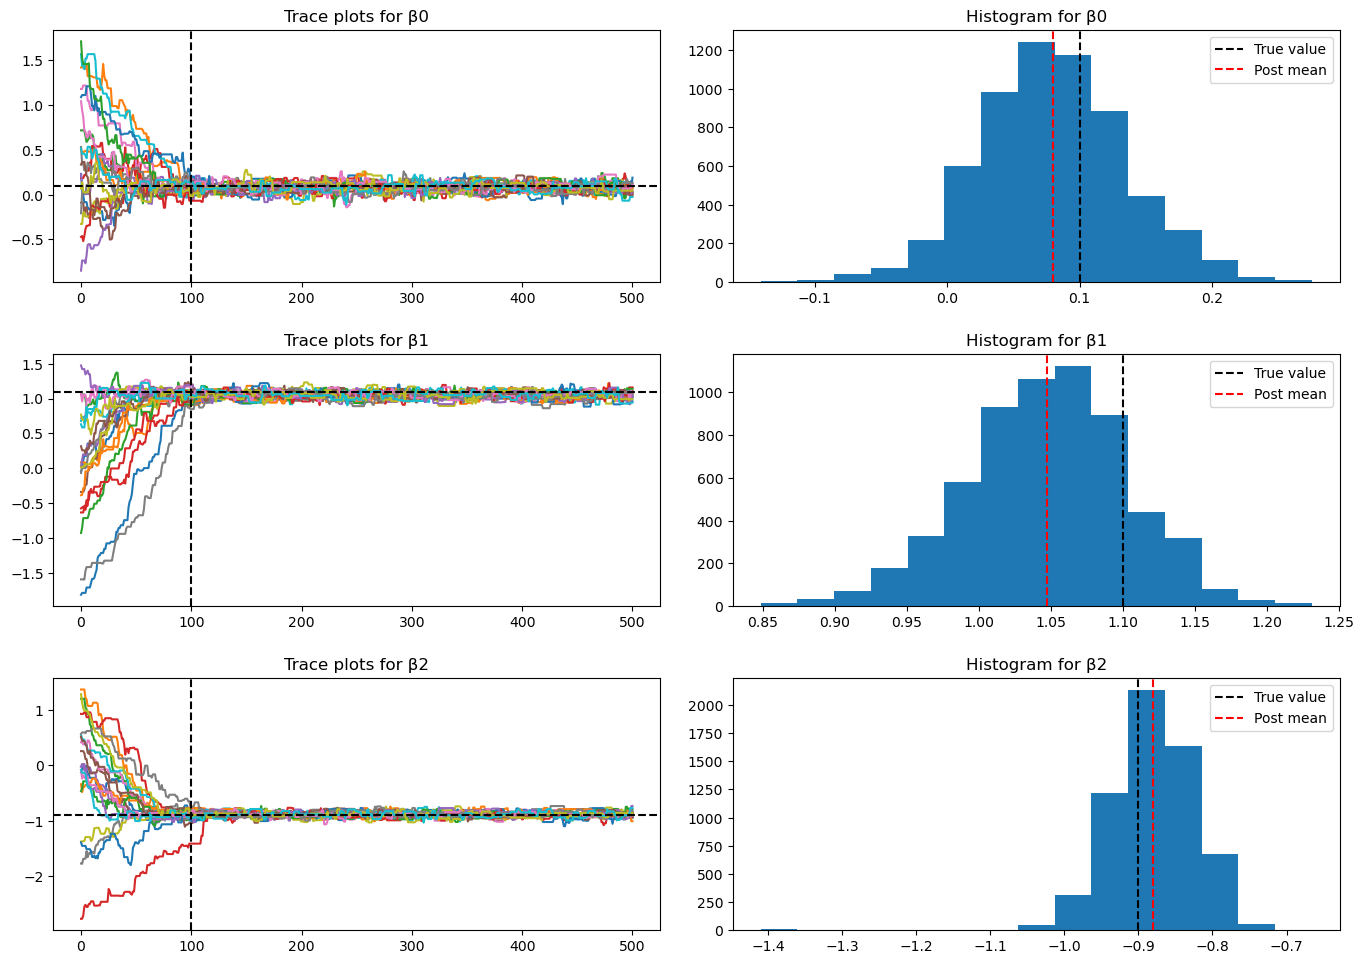

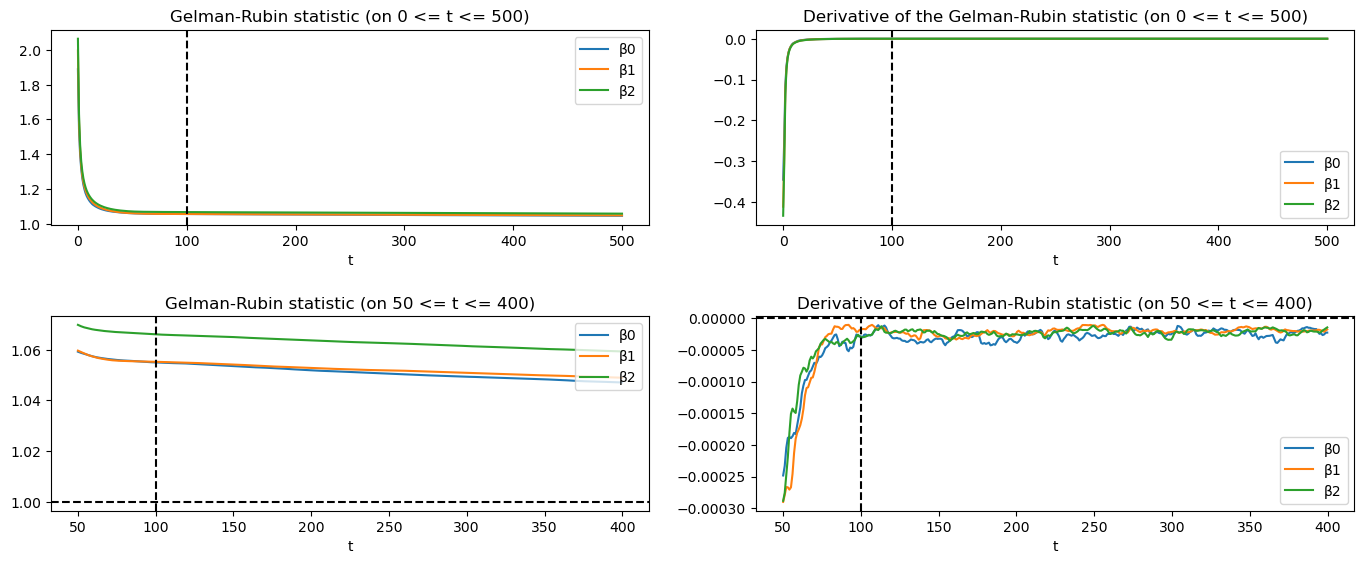

In [26]:
main_walker(N=2000,dof=3,c=0.007,M=20,burn_ind=100) ## 20 chains, 3 parameters, basic MH model, N=2000

# 3.)
I increase to 9 dimensions, with a true value of $\beta = (0.1,1.1,-0.9,0.091,-0.656,0.706,-0.640,0.177,-0.758)$. The estimate is $(0.113, 1.394, -1.121, 0.105, -0.481, 0.983, -0.857, 0.119, -0.783)$ with error $E_{MH} = (0.013, 0.294, 0.221, 0.014, 0.175, 0.277, 0.217, 0.058, 0.025)$. This takes $c=0.03$ and a burn-in period of $100$ iterations. The scaling had to be decreased to about a third of the scaling used in the 3-dimensional case. The accuracy doesn't seem to vary much between the two, but the burn-in period is longer; increasing the number of parameters requires longer runs to obtain the same level of accuracy, and a smaller proposal variance.

For $N=2000$, the estimate is $(0.061, 0.968, -0.808, 0.008, -0.553, 0.488, -0.405, 0.137, -0.652)$ with error $(0.039,0.132,0.092,0.083,0.103,0.218,0.235,0.04,0.106)$. This takes $c=0.004$ and a burn-in of $230$ iterations. As before, the burn-in period is longer than for $N=200,$ but the estimate is actually only better for about half the parameters, and slightly worse for the rest. This might be a sign that more iterations are needed to see a full improvement, although going to $N=4000$ showed similar behaviour..

For all, the Gelman-Rubin statistics match the burn-in periods from the trace plots, and converge to slightly above $1$.

True value of β: [ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 23.71
Parameters found: [ 0.113  1.394 -1.121  0.105 -0.481  0.983 -0.857  0.119 -0.783]
β0 - True mean: 0.1 | Posterior mean: 0.138 | Posterior standard deviation σ: 0.226 | Difference: 0.169σ
β1 - True mean: 1.1 | Posterior mean: 1.518 | Posterior standard deviation σ: 0.282 | Difference: 1.482σ
β2 - True mean: -0.9 | Posterior mean: -1.207 | Posterior standard deviation σ: 0.263 | Difference: 1.167σ
β3 - True mean: 0.091 | Posterior mean: 0.084 | Posterior standard deviation σ: 0.205 | Difference: 0.036σ
β4 - True mean: -0.656 | Posterior mean: -0.

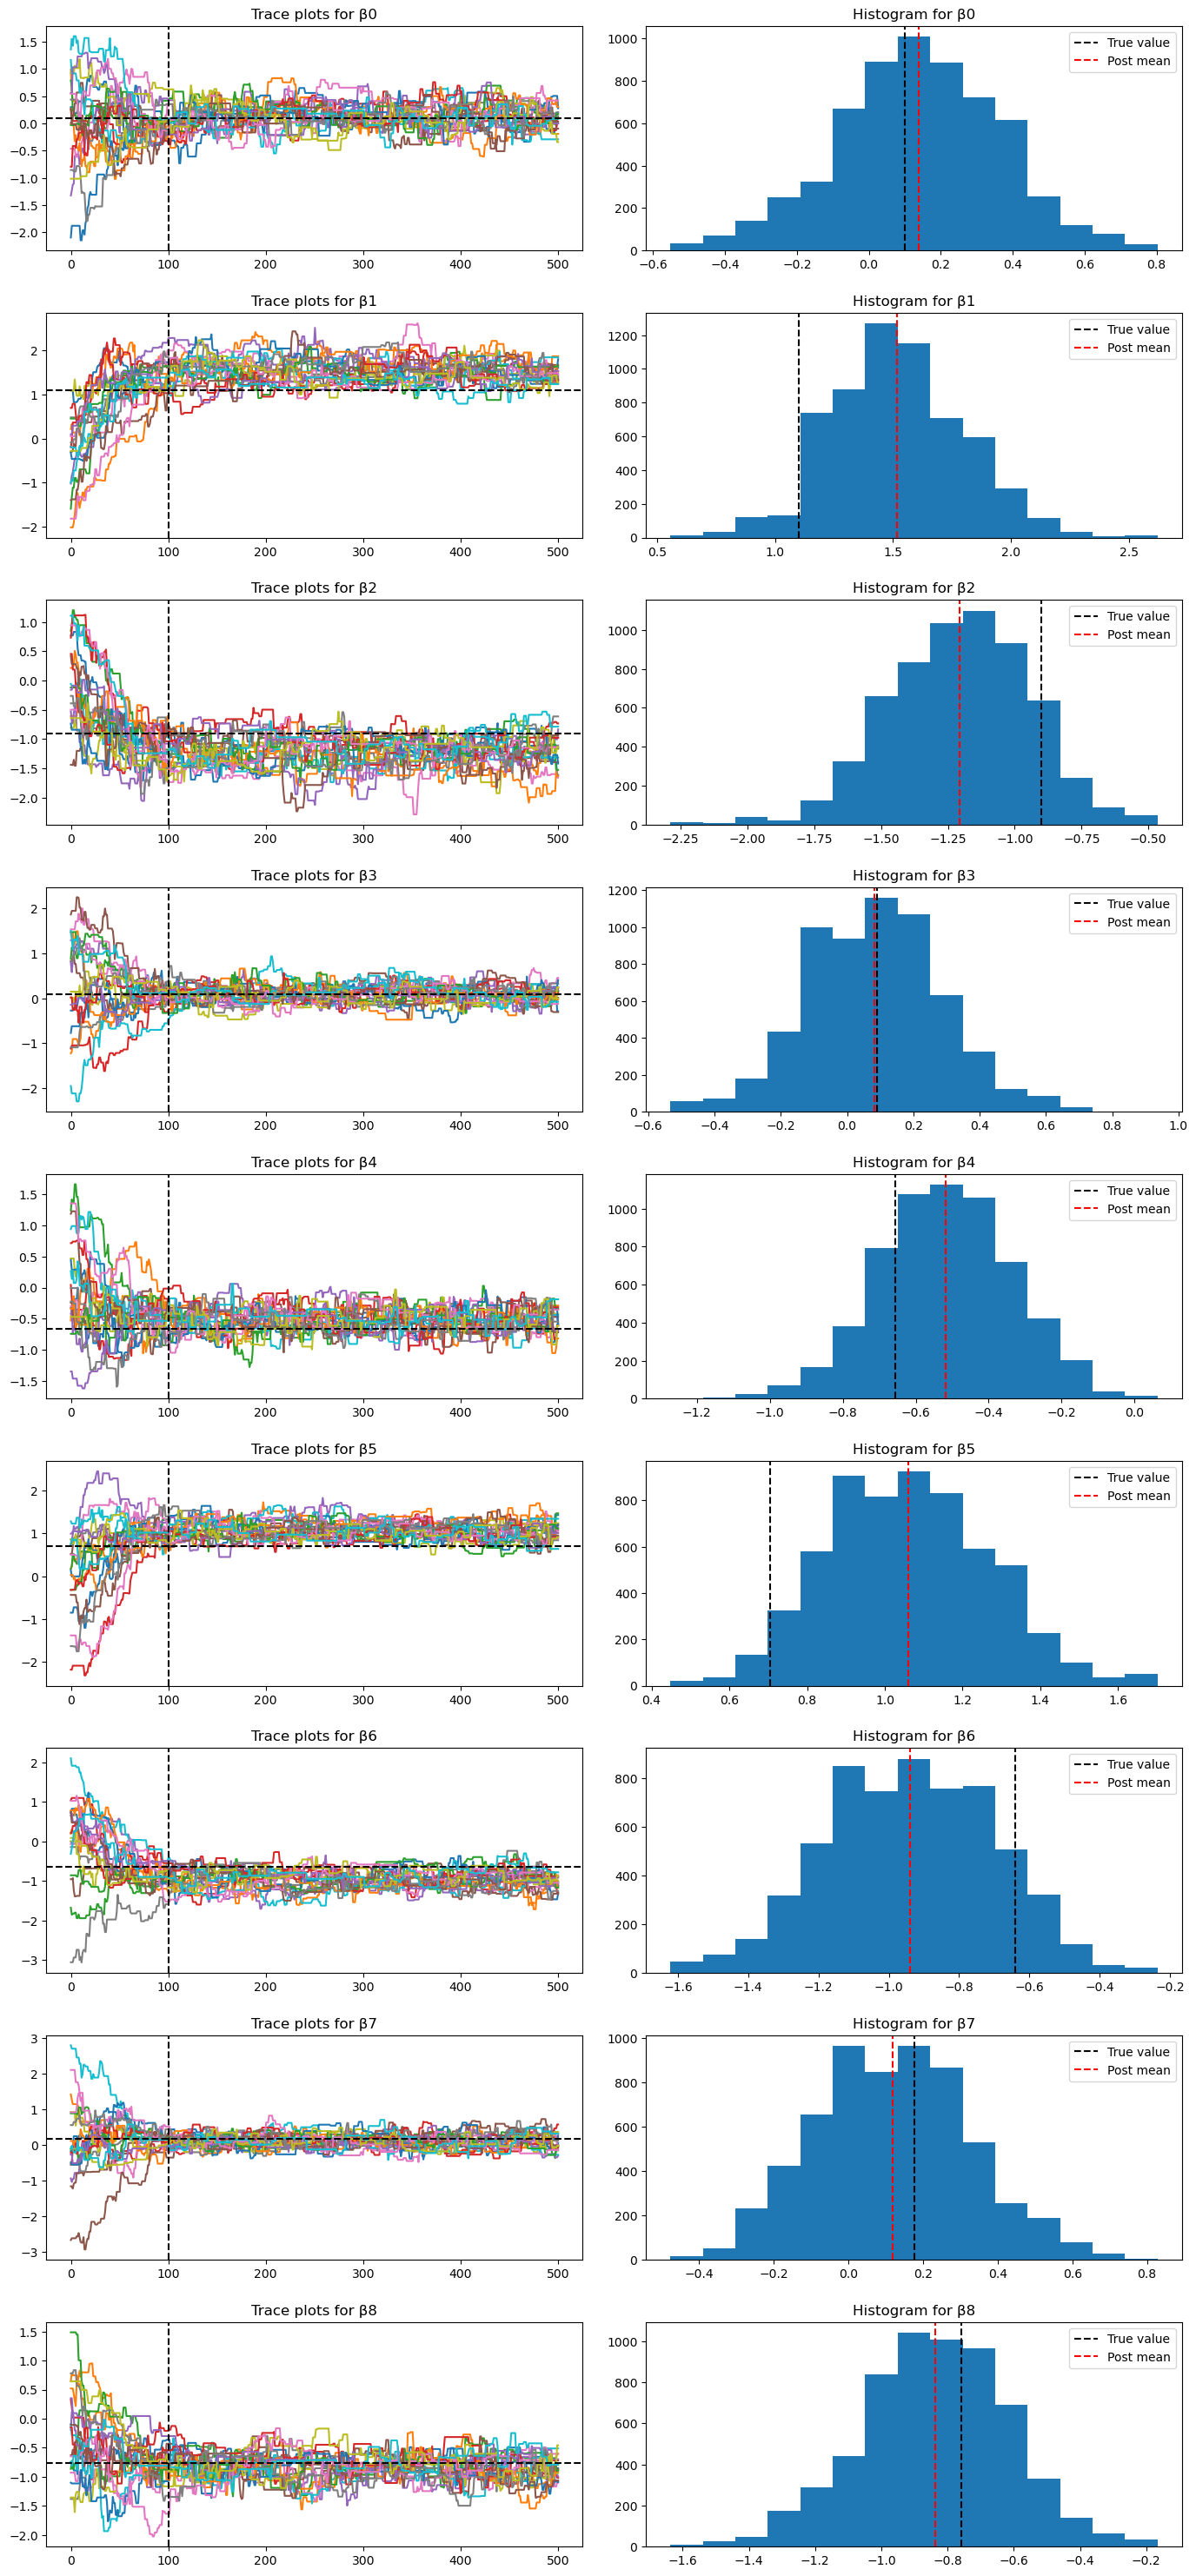

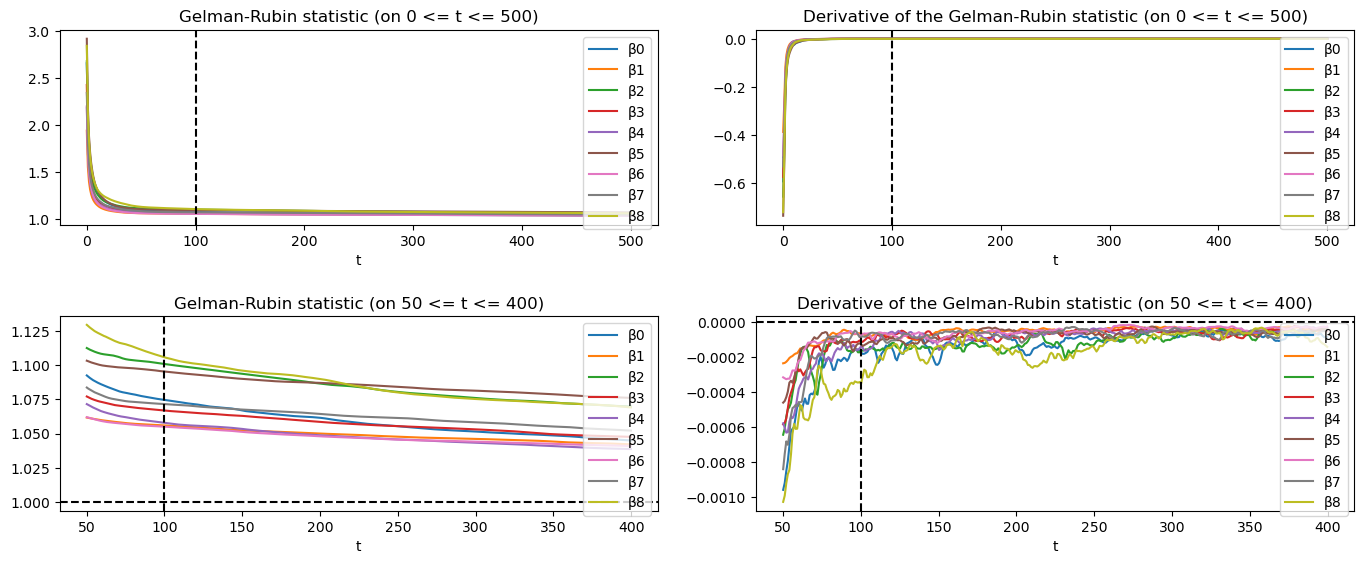

In [27]:
main_walker(N=200,dof=9,c=0.03,M=20,burn_ind=100) ## 20 chains, 9 parameters, basic MH model

True value of β: [ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 22.36
Parameters found: [ 0.061  0.968 -0.808  0.008 -0.553  0.488 -0.405  0.137 -0.652]
β0 - True mean: 0.1 | Posterior mean: 0.002 | Posterior standard deviation σ: 0.058 | Difference: 1.707σ
β1 - True mean: 1.1 | Posterior mean: 1.154 | Posterior standard deviation σ: 0.068 | Difference: 0.796σ
β2 - True mean: -0.9 | Posterior mean: -0.938 | Posterior standard deviation σ: 0.064 | Difference: 0.599σ
β3 - True mean: 0.091 | Posterior mean: 0.022 | Posterior standard deviation σ: 0.049 | Difference: 1.421σ
β4 - True mean: -0.656 | Posterior mean: -0.

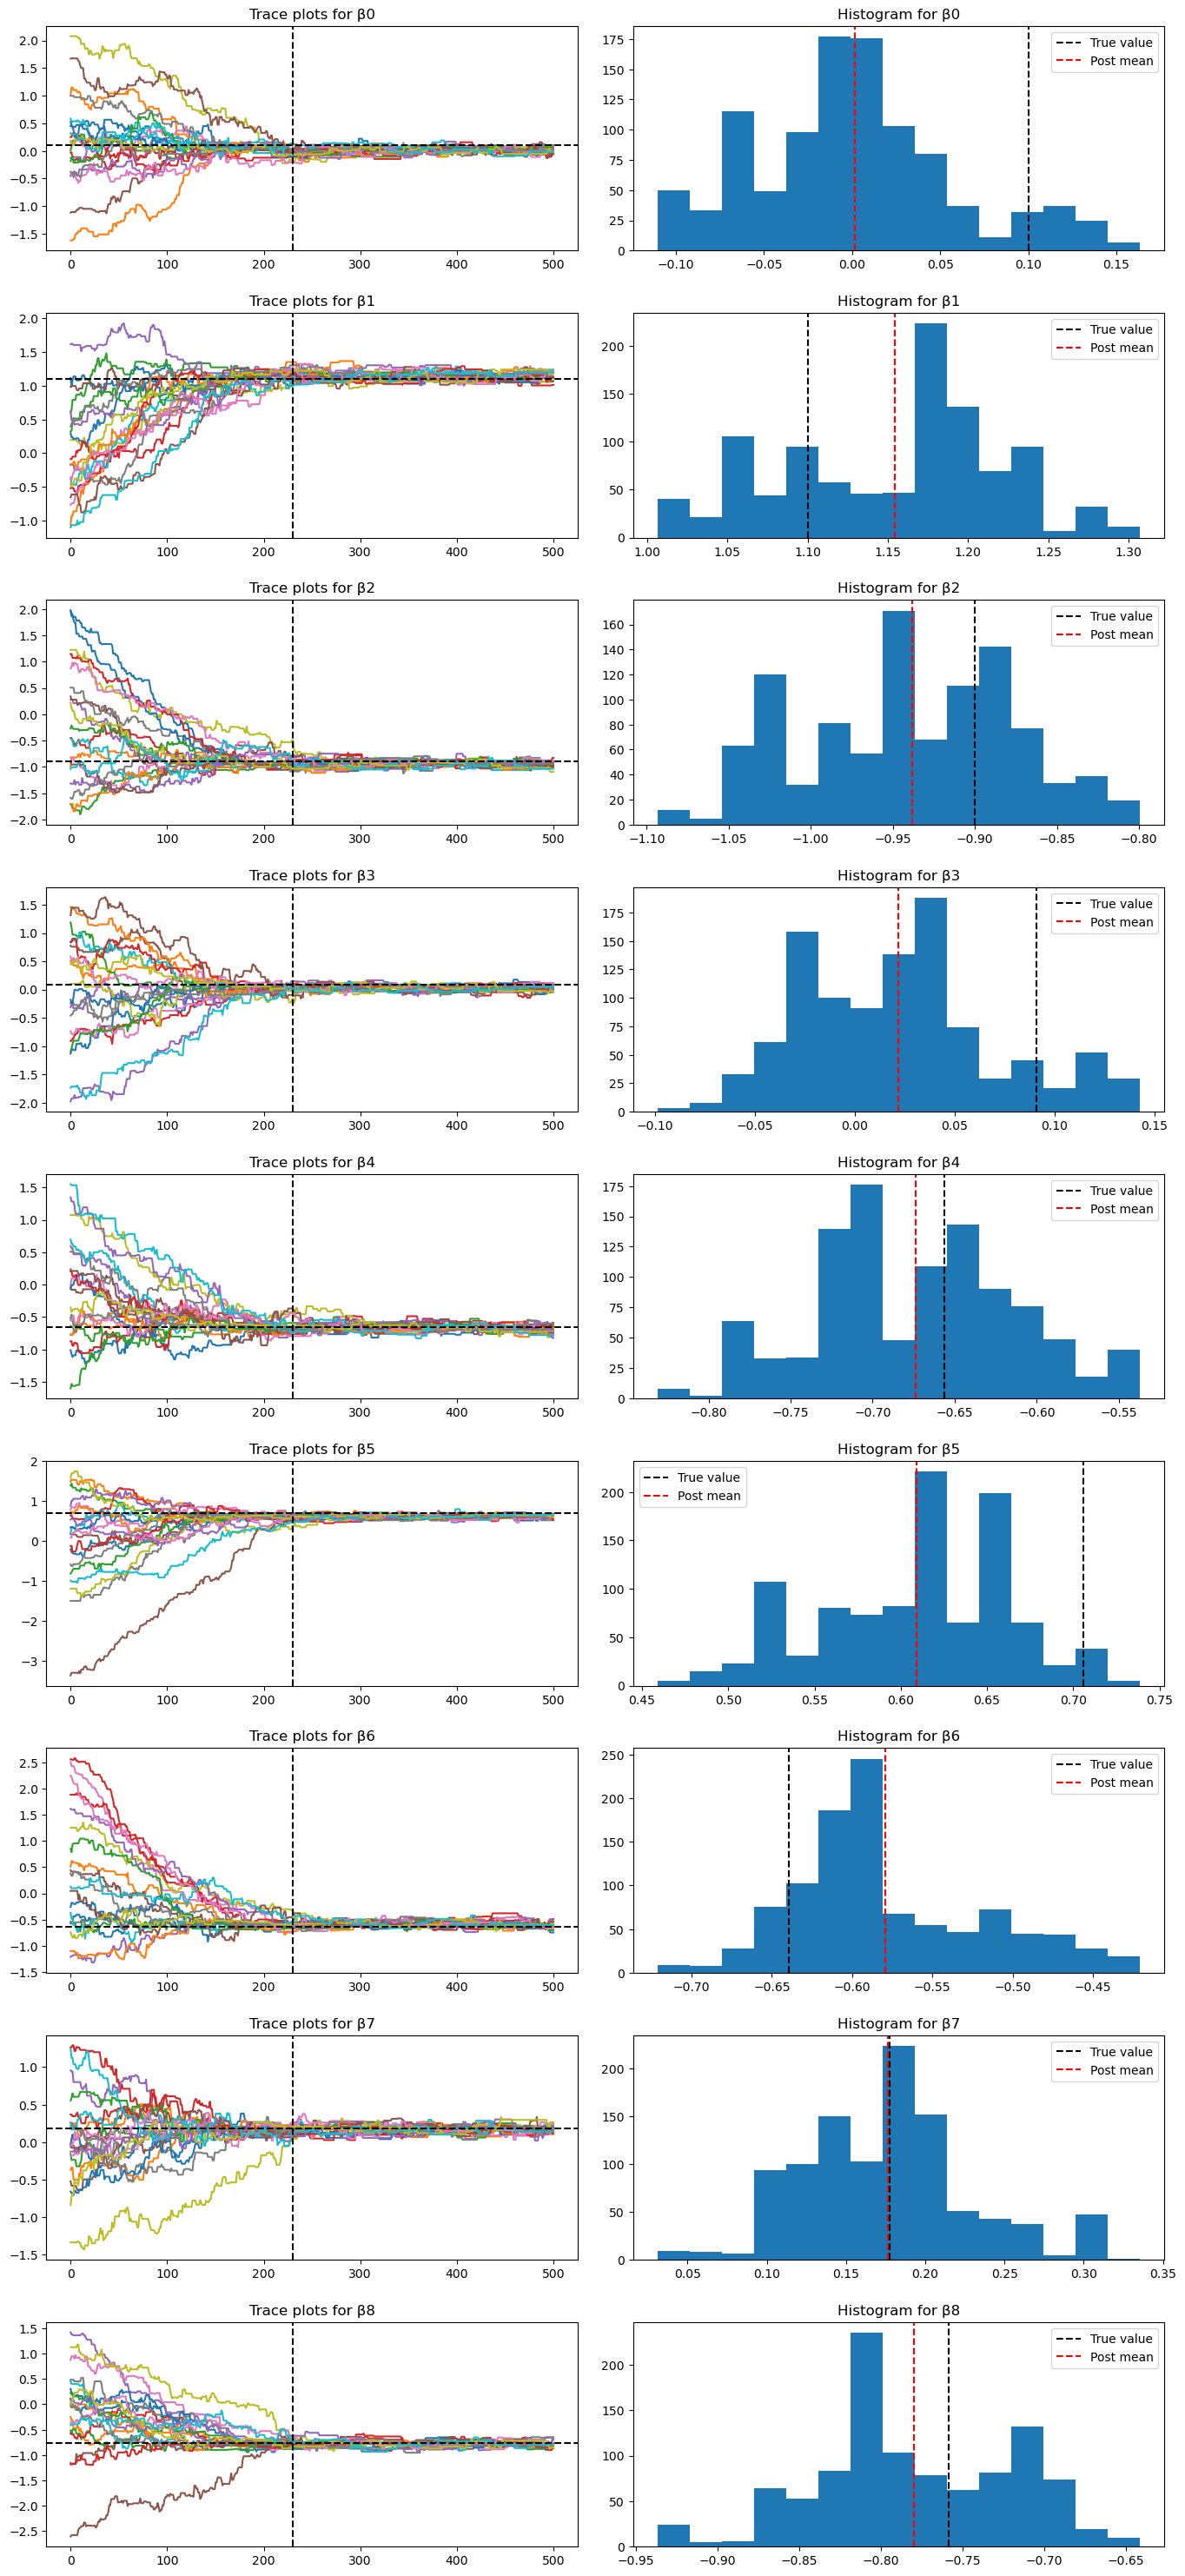

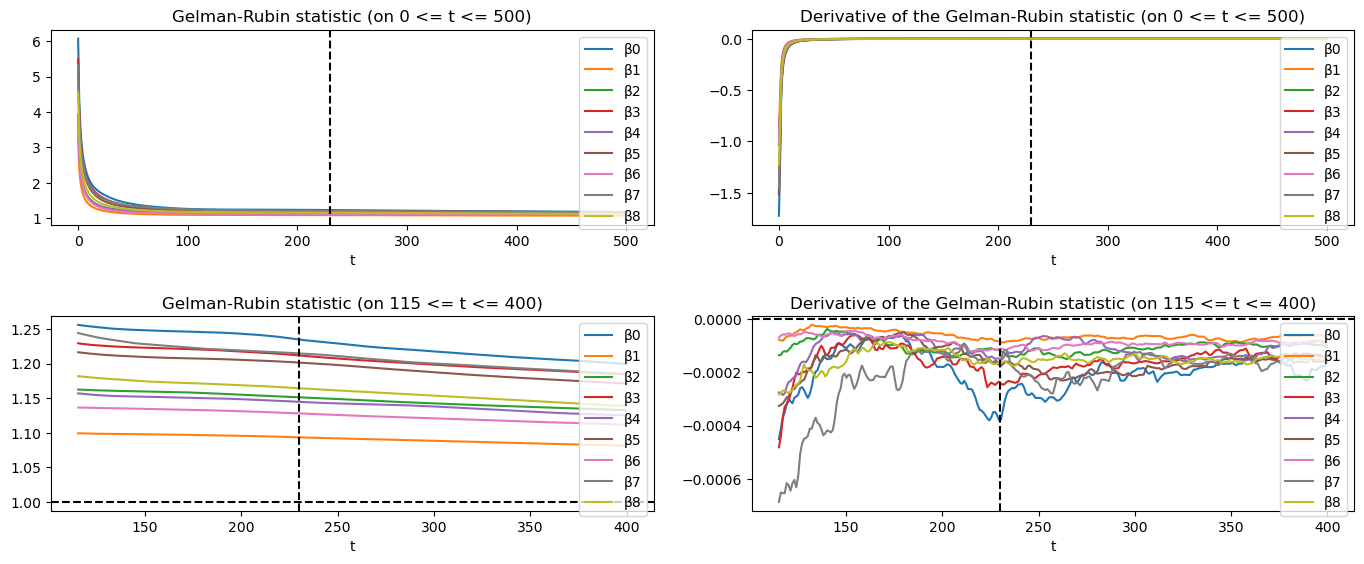

In [29]:
main_walker(N=2000,dof=9,c=0.004,M=20,burn_ind=230) ## 20 chains, 9 parameters, basic MH model

True value of β: [ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 19.06
Parameters found: [-0.002  0.985 -0.71   0.047 -0.392  0.664 -0.598  0.093 -0.563]
β0 - True mean: 0.1 | Posterior mean: 0.015 | Posterior standard deviation σ: 0.041 | Difference: 2.101σ
β1 - True mean: 1.1 | Posterior mean: 1.163 | Posterior standard deviation σ: 0.066 | Difference: 0.956σ
β2 - True mean: -0.9 | Posterior mean: -0.93 | Posterior standard deviation σ: 0.043 | Difference: 0.695σ
β3 - True mean: 0.091 | Posterior mean: 0.105 | Posterior standard deviation σ: 0.03 | Difference: 0.465σ
β4 - True mean: -0.656 | Posterior mean: -0.62

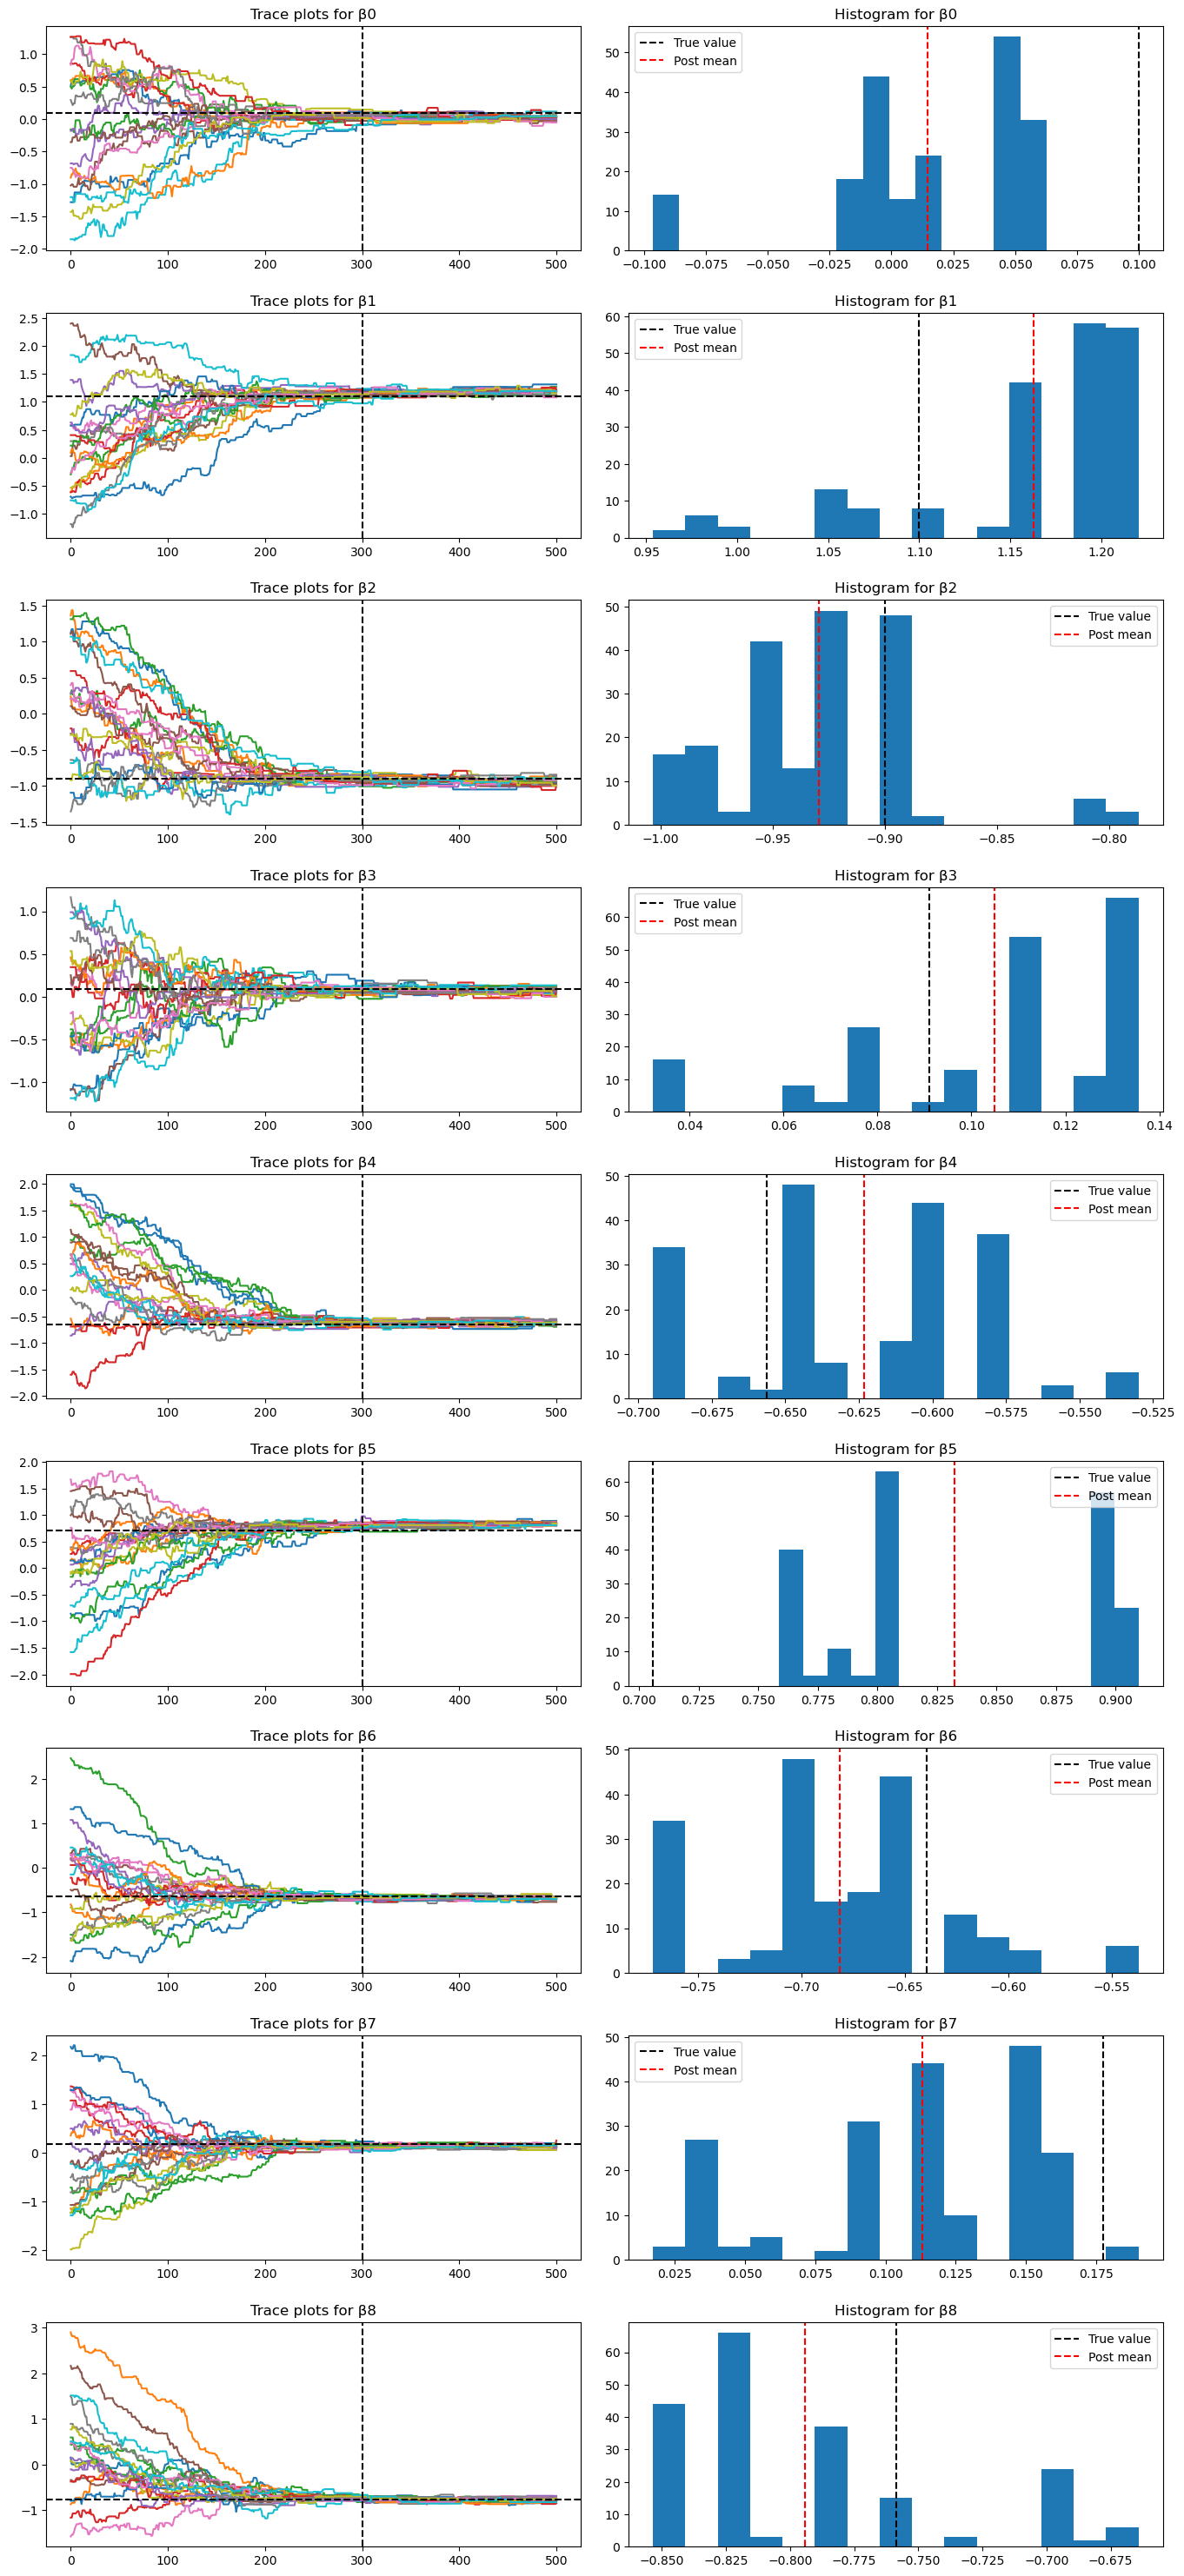

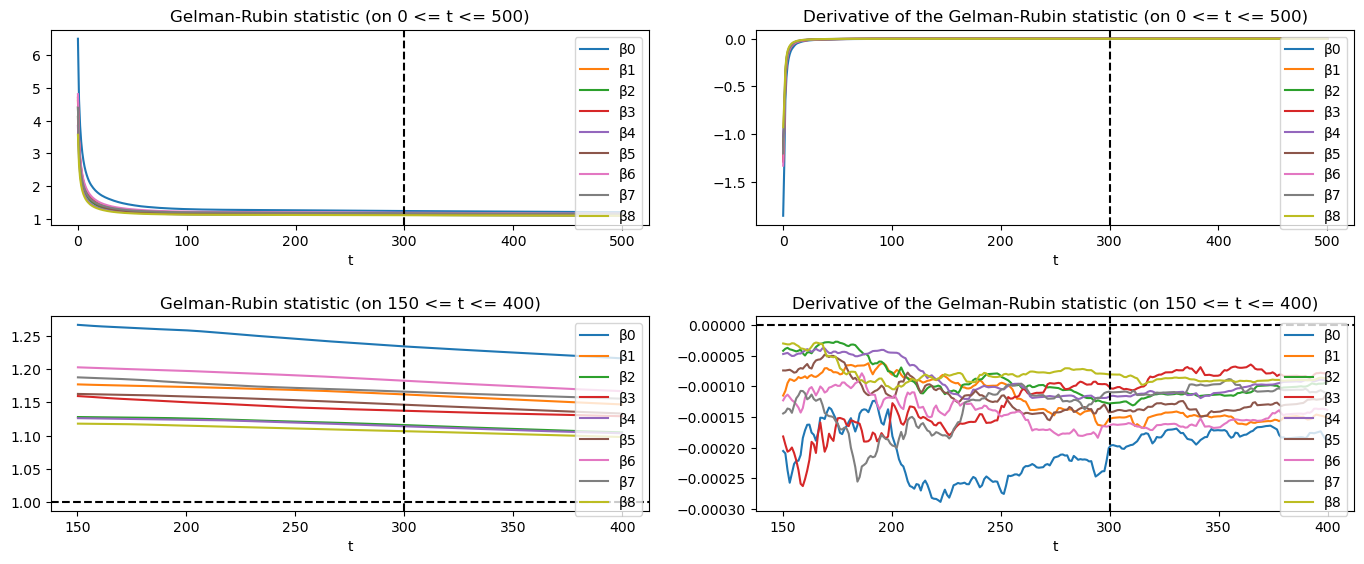

In [47]:
main_walker(N=4000,dof=9,c=0.004,M=20,burn_ind=300) ## 20 chains, 9 parameters, basic MH model

In [48]:
np.array([0.1,1.1,-0.9,0.0909,-0.6563,0.7059,-0.6396,0.1774,-0.7585]) - np.array([-0.002,0.985,-0.71,0.047,-0.392,0.664,-0.598,0.093,-0.563])

array([ 0.102 ,  0.115 , -0.19  ,  0.0439, -0.2643,  0.0419, -0.0416,
        0.0844, -0.1955])

# 4.)
I update to a Metropolis-within-Gibbs model, with the same $9$ parameters as before, and $M=10$ chains. To reach approximately a $15\%$ acceptance rate for each sampler, I found the variance for each component was $(1.5,1.5,1.5,1.2,1.7,1.4,1.5,1.9,1.5)$. They are not all the same unlike for the regular random-walk model, and changing one did affect the acceptance rate for the other samplers.

I find an estimate $(0.111,1.548,-1.198,0.079,-0.506,1.049,-0.956,0.107,-0.803)$ with error $E_{MWG}=(0.011,0.448, 0.298, 0.0119, 0.1503, 0.3431, 0.3164,0.0704, 0.0445)$. The burn-in period is about $30$ from the trace plots, although plotting the derivative of the Gelman-Rubin statistic suggests $50$ as a better choice, so I used it. This is less than the period of $100$ for the regular Metropolis model, meaning the Gelman-Rubin statistic goes to $1$ faster here. Comparing the magnitudes supports this; after the burn-in period the statistic is in the range $(1.01,1.08)$ for Metropolis-within-Gibbs compared to $(1.04,1.11)$ for Metropolis-Hastings.

The difference in errors is $E_{MWG} - E_{MH} = -0.002,0.154,0.077,-0.0021,-0.0247,0.0661,0.0994, 0.0124 0.01955),$ meaning that as a whole this model gives a slightly worse estimate of $\beta$.

In [58]:
abs(np.array([0.111,1.548,-1.198,0.079,-0.506,1.049,-0.956,0.107,-0.803])-np.array([0.1,1.1,-0.9,0.0909,-0.6563,0.7059,-0.6396,0.1774,-0.7585]))

array([0.011 , 0.448 , 0.298 , 0.0119, 0.1503, 0.3431, 0.3164, 0.0704,
       0.0445])

In [61]:
sum(np.array([0.011,0.448,0.298,0.0119,0.1503,0.3431,0.3164,0.0704,0.0445]) - np.array([0.013, 0.294, 0.221, 0.014, 0.175, 0.277, 0.217, 0.058, 0.025]))

0.39960000000000007

True value of β: [ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
--------------------------------------------------------
Average acceptance rate [16.38 16.22 14.54 14.9  15.36 15.86 16.1  13.96 19.08]
Parameters found: [ 0.111  1.548 -1.198  0.079 -0.506  1.049 -0.956  0.107 -0.803]
β0 - True mean: 0.1 | Posterior mean: 0.112 | Posterior standard deviation σ: 0.222 | Difference: 0.054σ
β1 - True mean: 1.1 | Posterior mean: 1.525 | Posterior standard deviation σ: 0.264 | Difference: 1.61σ
β2 - True mean: -0.9 | Posterior mean: -1.191 | Posterior standard deviation σ: 0.253 | Difference: 1.151σ
β3 - True mean: 0.091 | Posterior mean: 0.087 | Posterior standard deviation σ: 0.195 | Difference: 0.019σ
β4 - True mean: -0.656 | Posterior mean: -0.502 | Posterior standard deviation σ: 0.202 | Difference: 0.764σ
β5 - True mean: 0.706 | Po

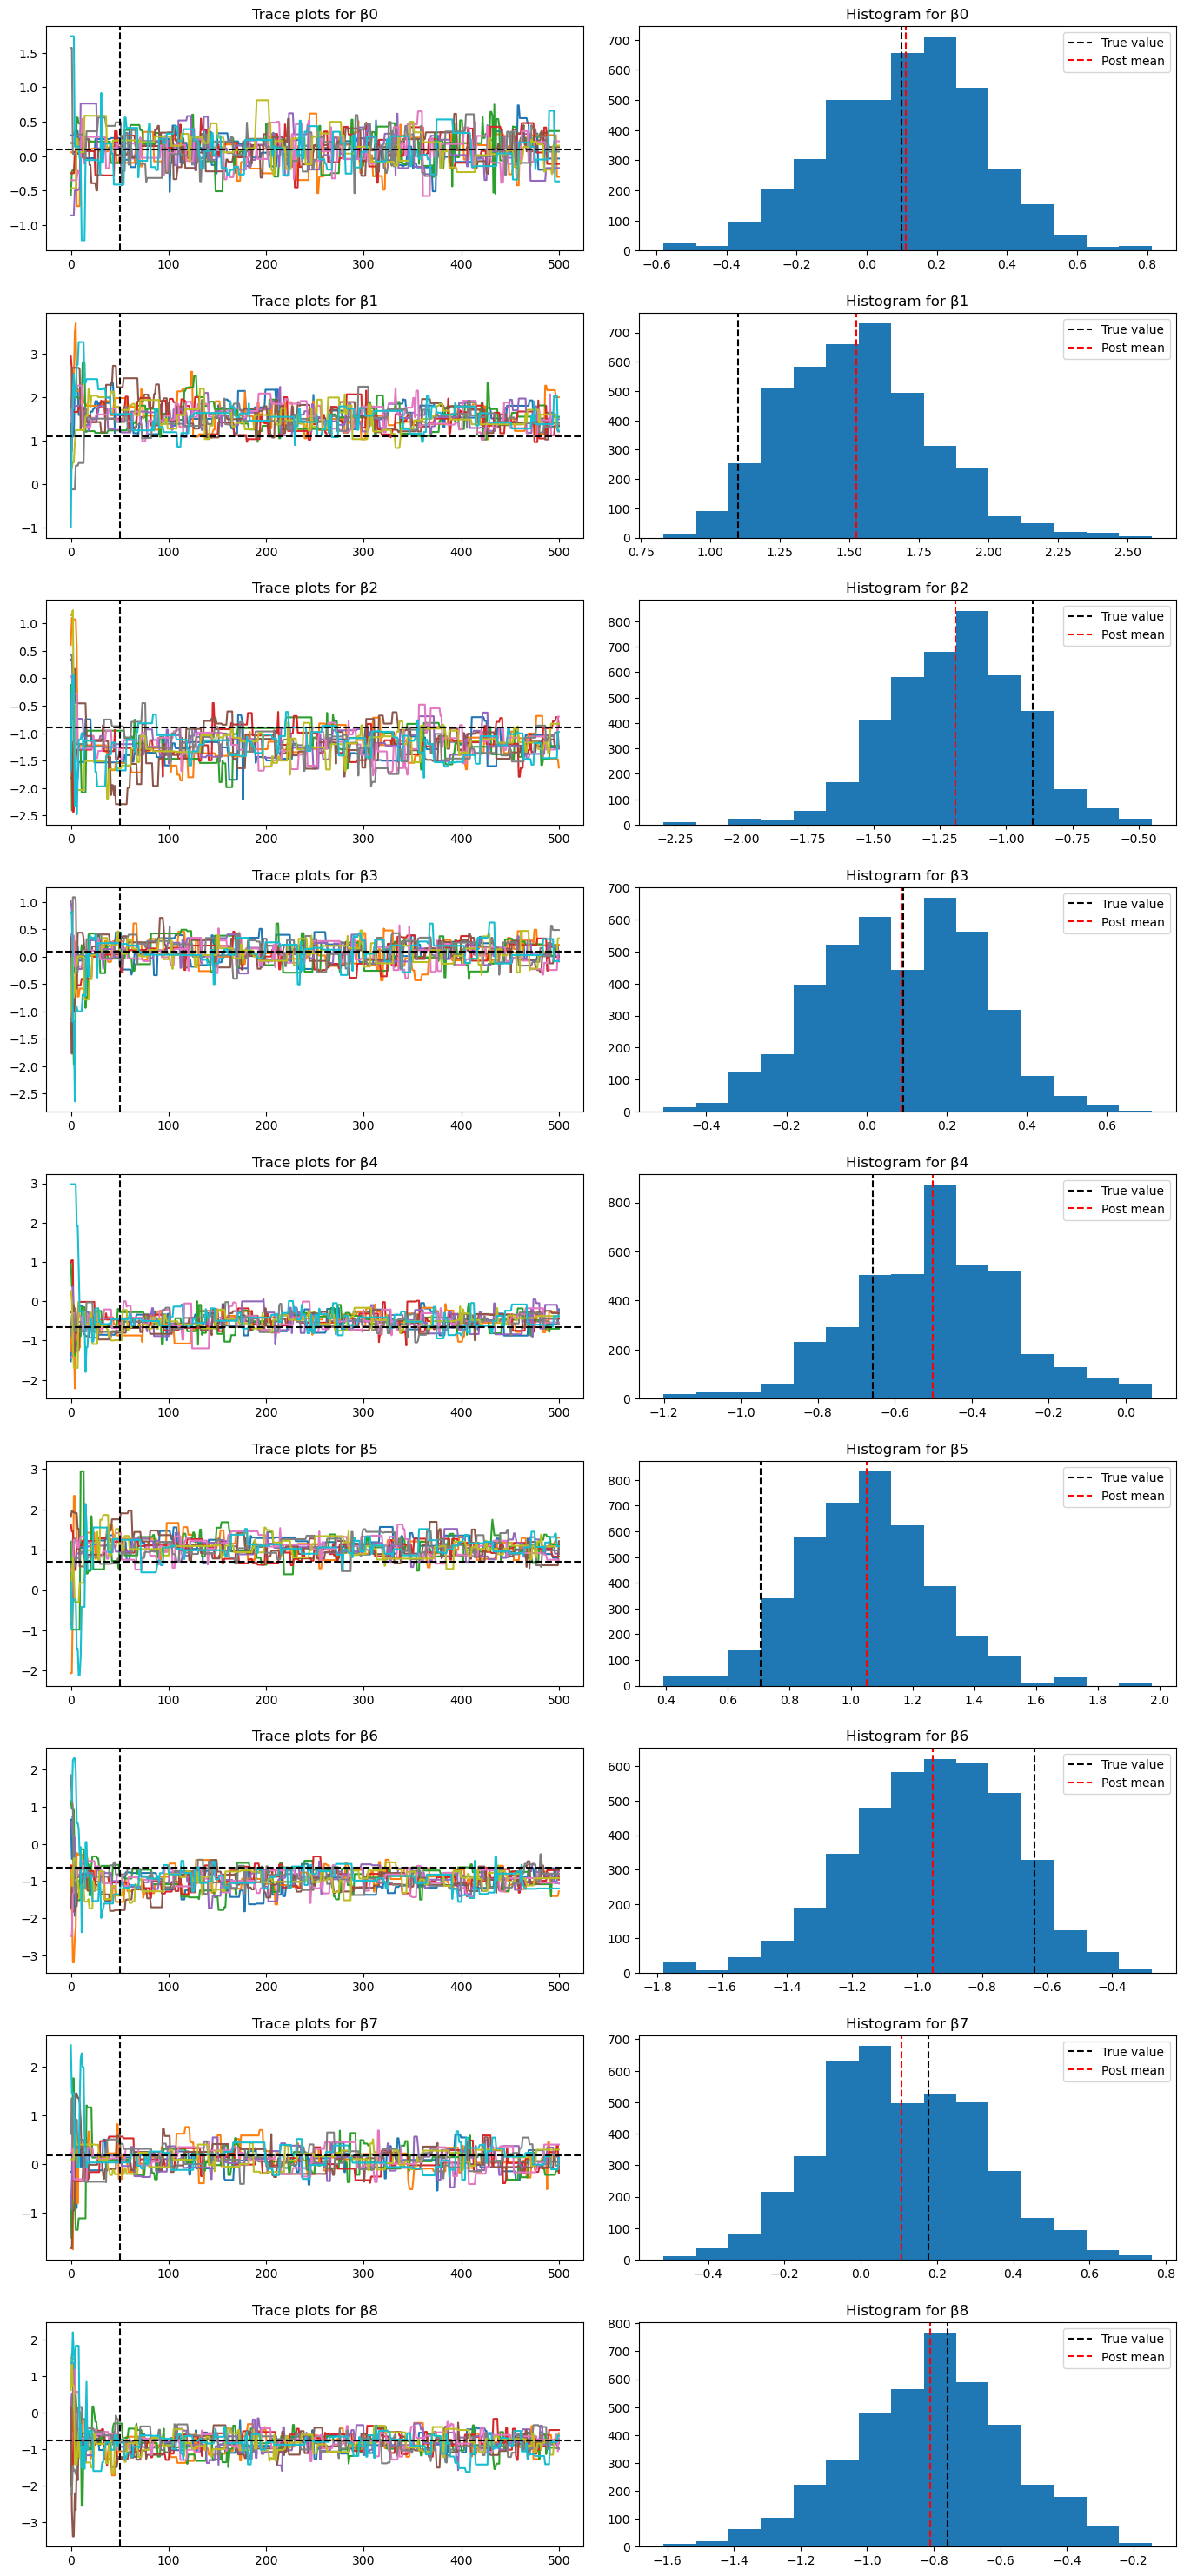

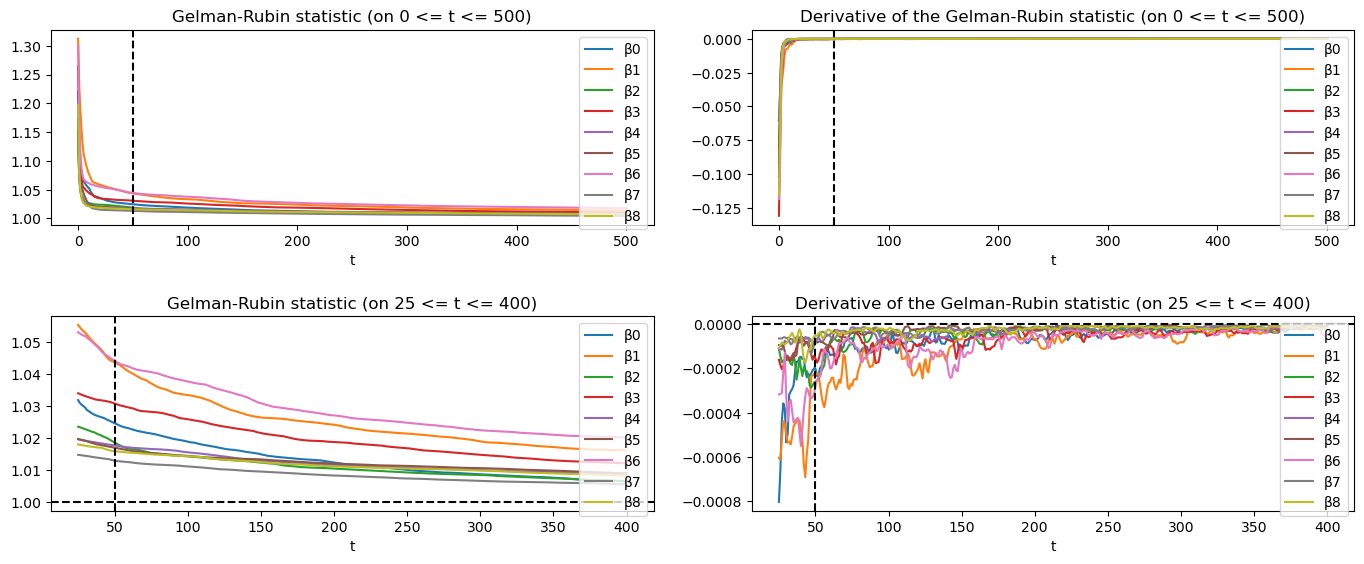

In [59]:
c0 = [1.7, 1.7, 1.7, 1.5, 1.5, 1.45, 1.6, 1.89, 1.4]

main_walker(N=200,dof=9,c=c0,M=10,burn_ind=50,Gibbs=True) ## 10 chains, 9 parameters, MWG model

# 5.)
Finally, I alternate between two proposals. A variance of $c=0.022$ gives an acceptance rate of $30\%$, and a variance of $c=0.074$ gives an acceptance rate of $10\%$. When chosen with equal probability, the overall acceptance rate is $20.15\%$, similar to the basic Metropolis-Hastings model. The estimate is $(0.076, 1.395, -1.162, 0.087, -0.475, 0.984, -0.885, 0.106, -0.781)$ with error $E_{TP} = (0.024, 0.295, 0.262, 0.0039, 0.1813, 0.2781, 0.2454, 0.0714,  0.025)$. This is quite similar to the error $E_{MH}$ from the basic model, and $E_{TP} - E_{MH} = (0.011,0.001,0.041,-0.0101,0.0063,0.0011,0.0284,0.0134,-0.0025).$ It seems to converge after a burn-in period of $120$ iterations, which is actually slightly worse than for the Metropolis model. It takes longer to converge to stationarity.

Increasing to $N=2000$ iterations gives an estimate $(-0.017,1.12,-0.855,-0.014,-0.562,0.584,-0.5,0.186,-0.71)$ with error $(0.117,0.02,0.045,0.1049,0.0943,0.1219,0.1396,0.0086, 0.0485$). While some of the errors are slightly worse than for $N=100$, as a whole this is a more accurate estimate of $\beta$. I used variances $c=0.015$ for $10\%$ acceptance and $c=0.003$ for $30\%$ with an overall acceptance of $18.25\%$.

In [62]:
np.array([0.024, 0.295, 0.262, 0.0039, 0.1813, 0.2781, 0.2454, 0.0714, 0.0225])-np.array([0.013, 0.294, 0.221, 0.014, 0.175, 0.277, 0.217, 0.058, 0.025])

array([ 0.011 ,  0.001 ,  0.041 , -0.0101,  0.0063,  0.0011,  0.0284,
        0.0134, -0.0025])

True value of β: [ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 20.15
Parameters found: [ 0.076  1.395 -1.162  0.087 -0.475  0.984 -0.885  0.106 -0.781]
β0 - True mean: 0.1 | Posterior mean: 0.114 | Posterior standard deviation σ: 0.23 | Difference: 0.06σ
β1 - True mean: 1.1 | Posterior mean: 1.551 | Posterior standard deviation σ: 0.294 | Difference: 1.537σ
β2 - True mean: -0.9 | Posterior mean: -1.264 | Posterior standard deviation σ: 0.269 | Difference: 1.353σ
β3 - True mean: 0.091 | Posterior mean: 0.094 | Posterior standard deviation σ: 0.187 | Difference: 0.014σ
β4 - True mean: -0.656 | Posterior mean: -0.50

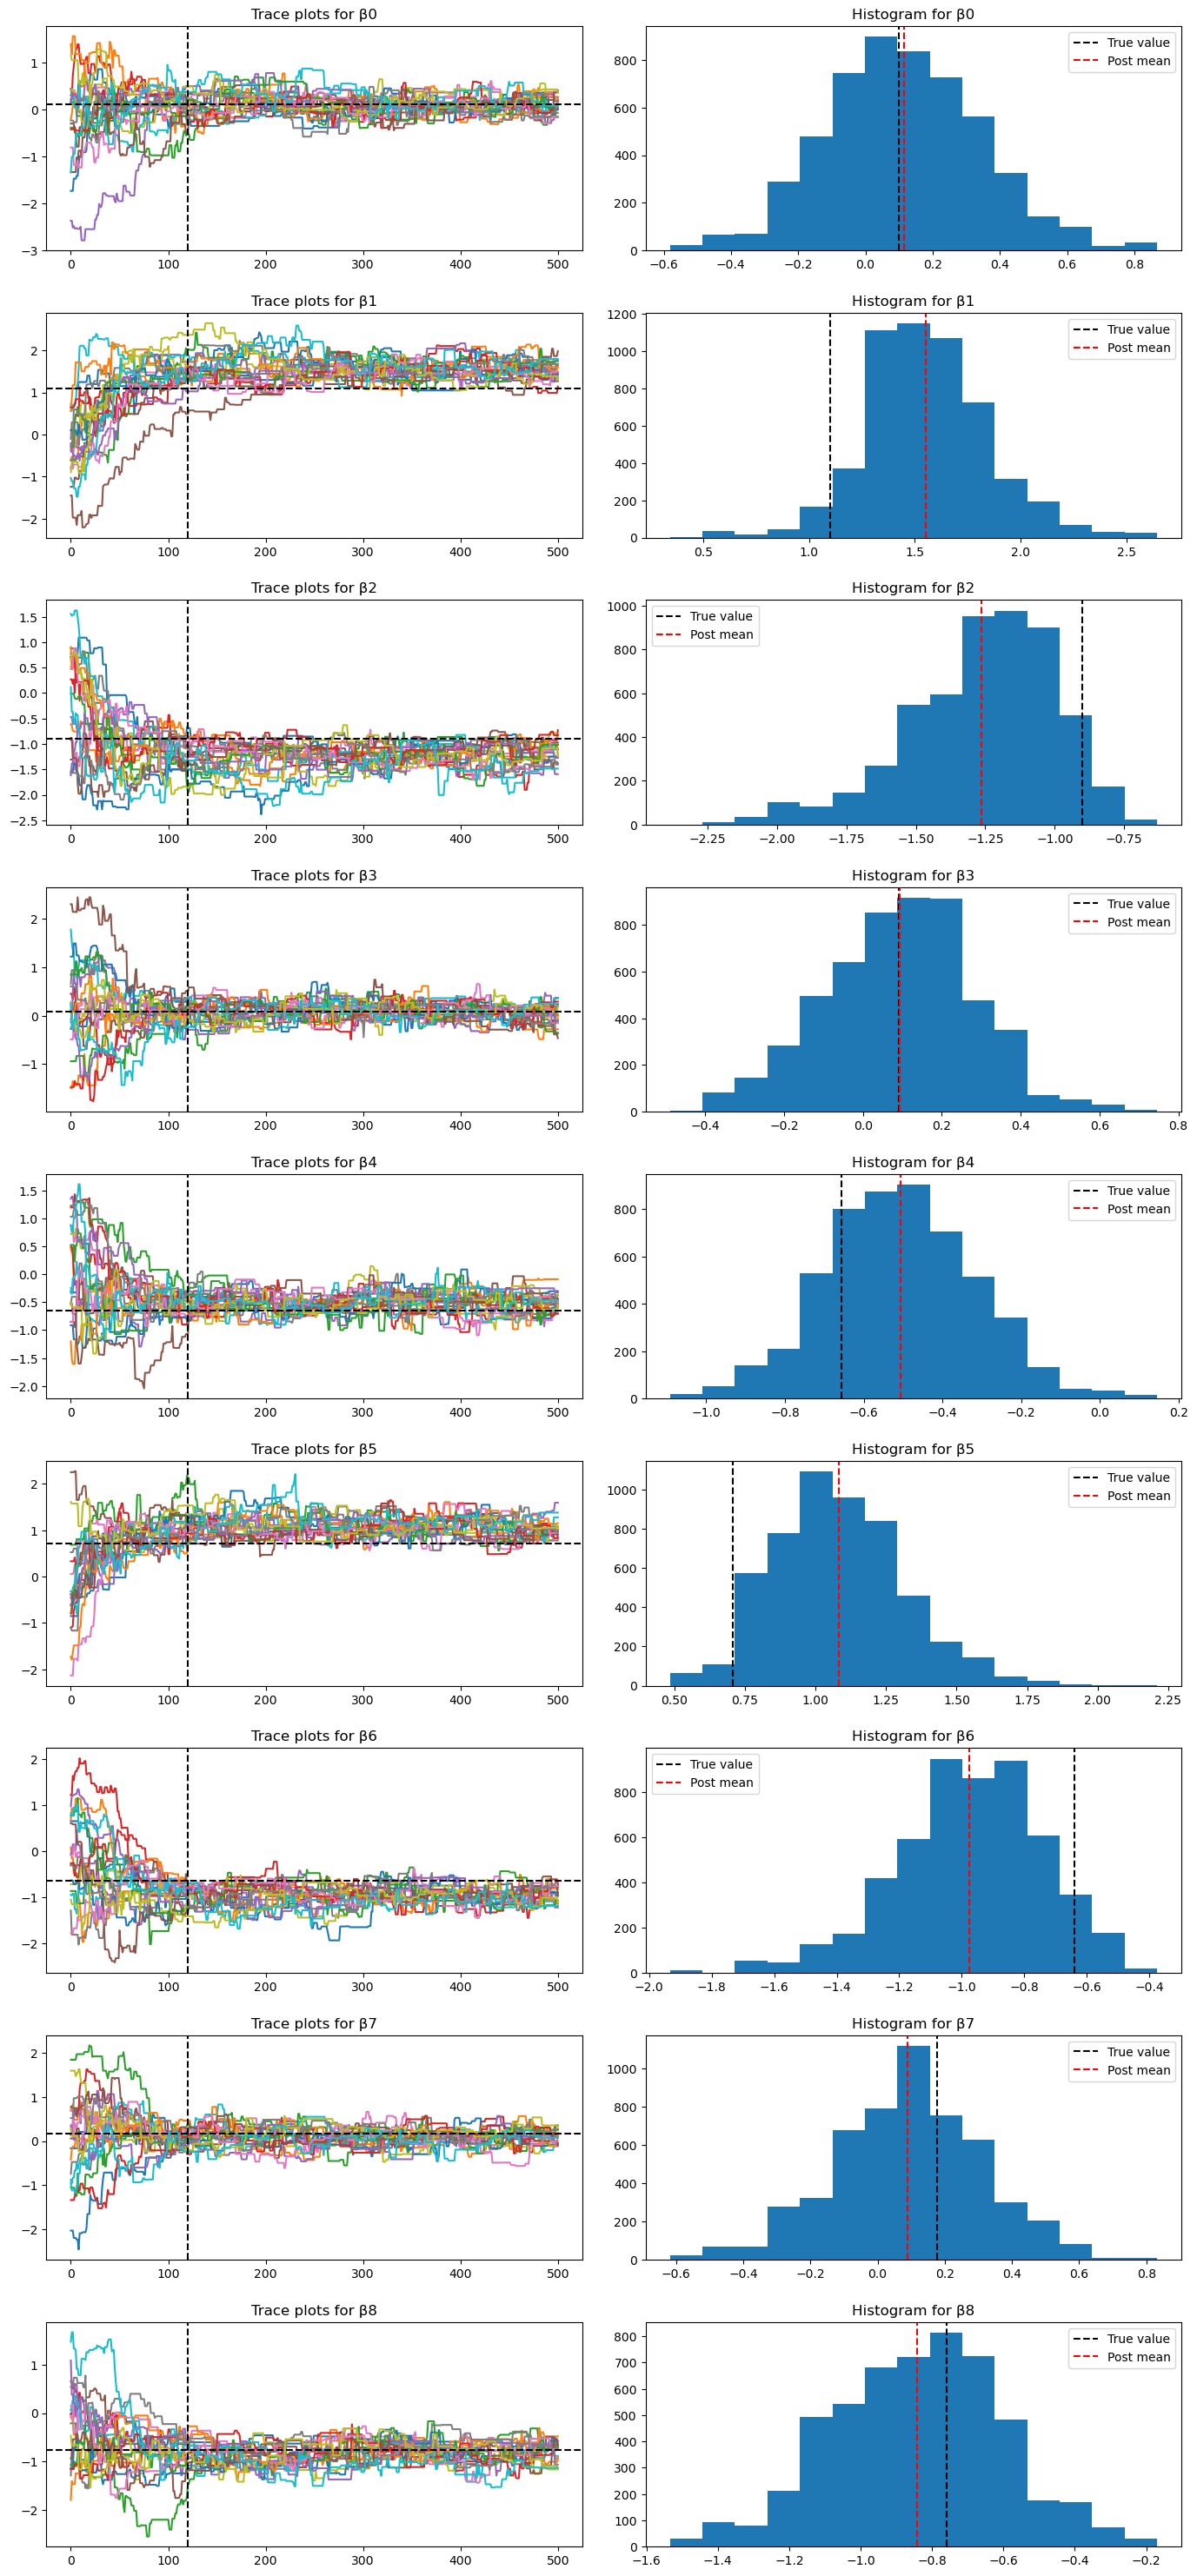

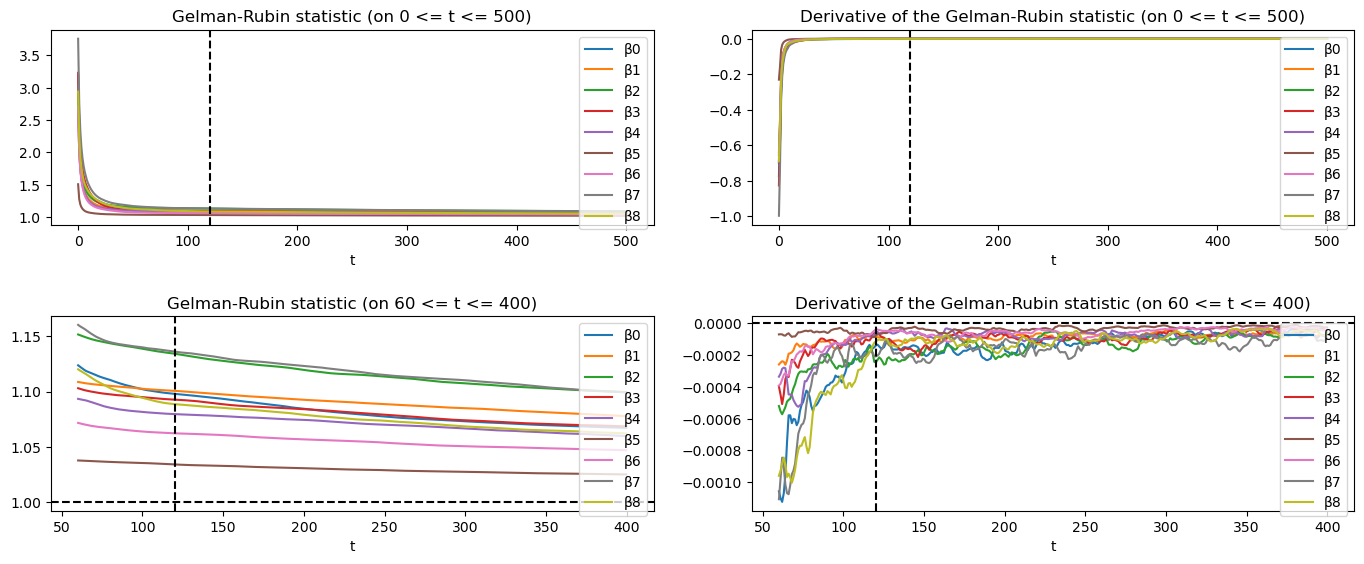

In [35]:
main_walker(N=200,dof=9,M=20,burn_ind=120,two_proposal=True) ## 20 chains, 9 parameters, choose between two proposals

True value of β: [ 0.1     1.1    -0.9     0.0909 -0.6563  0.7059 -0.6396  0.1774 -0.7585]
Chain 1 done
Chain 2 done
Chain 3 done
Chain 4 done
Chain 5 done
Chain 6 done
Chain 7 done
Chain 8 done
Chain 9 done
Chain 10 done
Chain 11 done
Chain 12 done
Chain 13 done
Chain 14 done
Chain 15 done
Chain 16 done
Chain 17 done
Chain 18 done
Chain 19 done
Chain 20 done
--------------------------------------------------------
Average acceptance rate 18.25
Parameters found: [-0.017  1.12  -0.855 -0.014 -0.562  0.584 -0.5    0.186 -0.71 ]
β0 - True mean: 0.1 | Posterior mean: -0.006 | Posterior standard deviation σ: 0.064 | Difference: 1.661σ
β1 - True mean: 1.1 | Posterior mean: 1.154 | Posterior standard deviation σ: 0.068 | Difference: 0.801σ
β2 - True mean: -0.9 | Posterior mean: -0.946 | Posterior standard deviation σ: 0.063 | Difference: 0.729σ
β3 - True mean: 0.091 | Posterior mean: 0.023 | Posterior standard deviation σ: 0.061 | Difference: 1.115σ
β4 - True mean: -0.656 | Posterior mean: -0

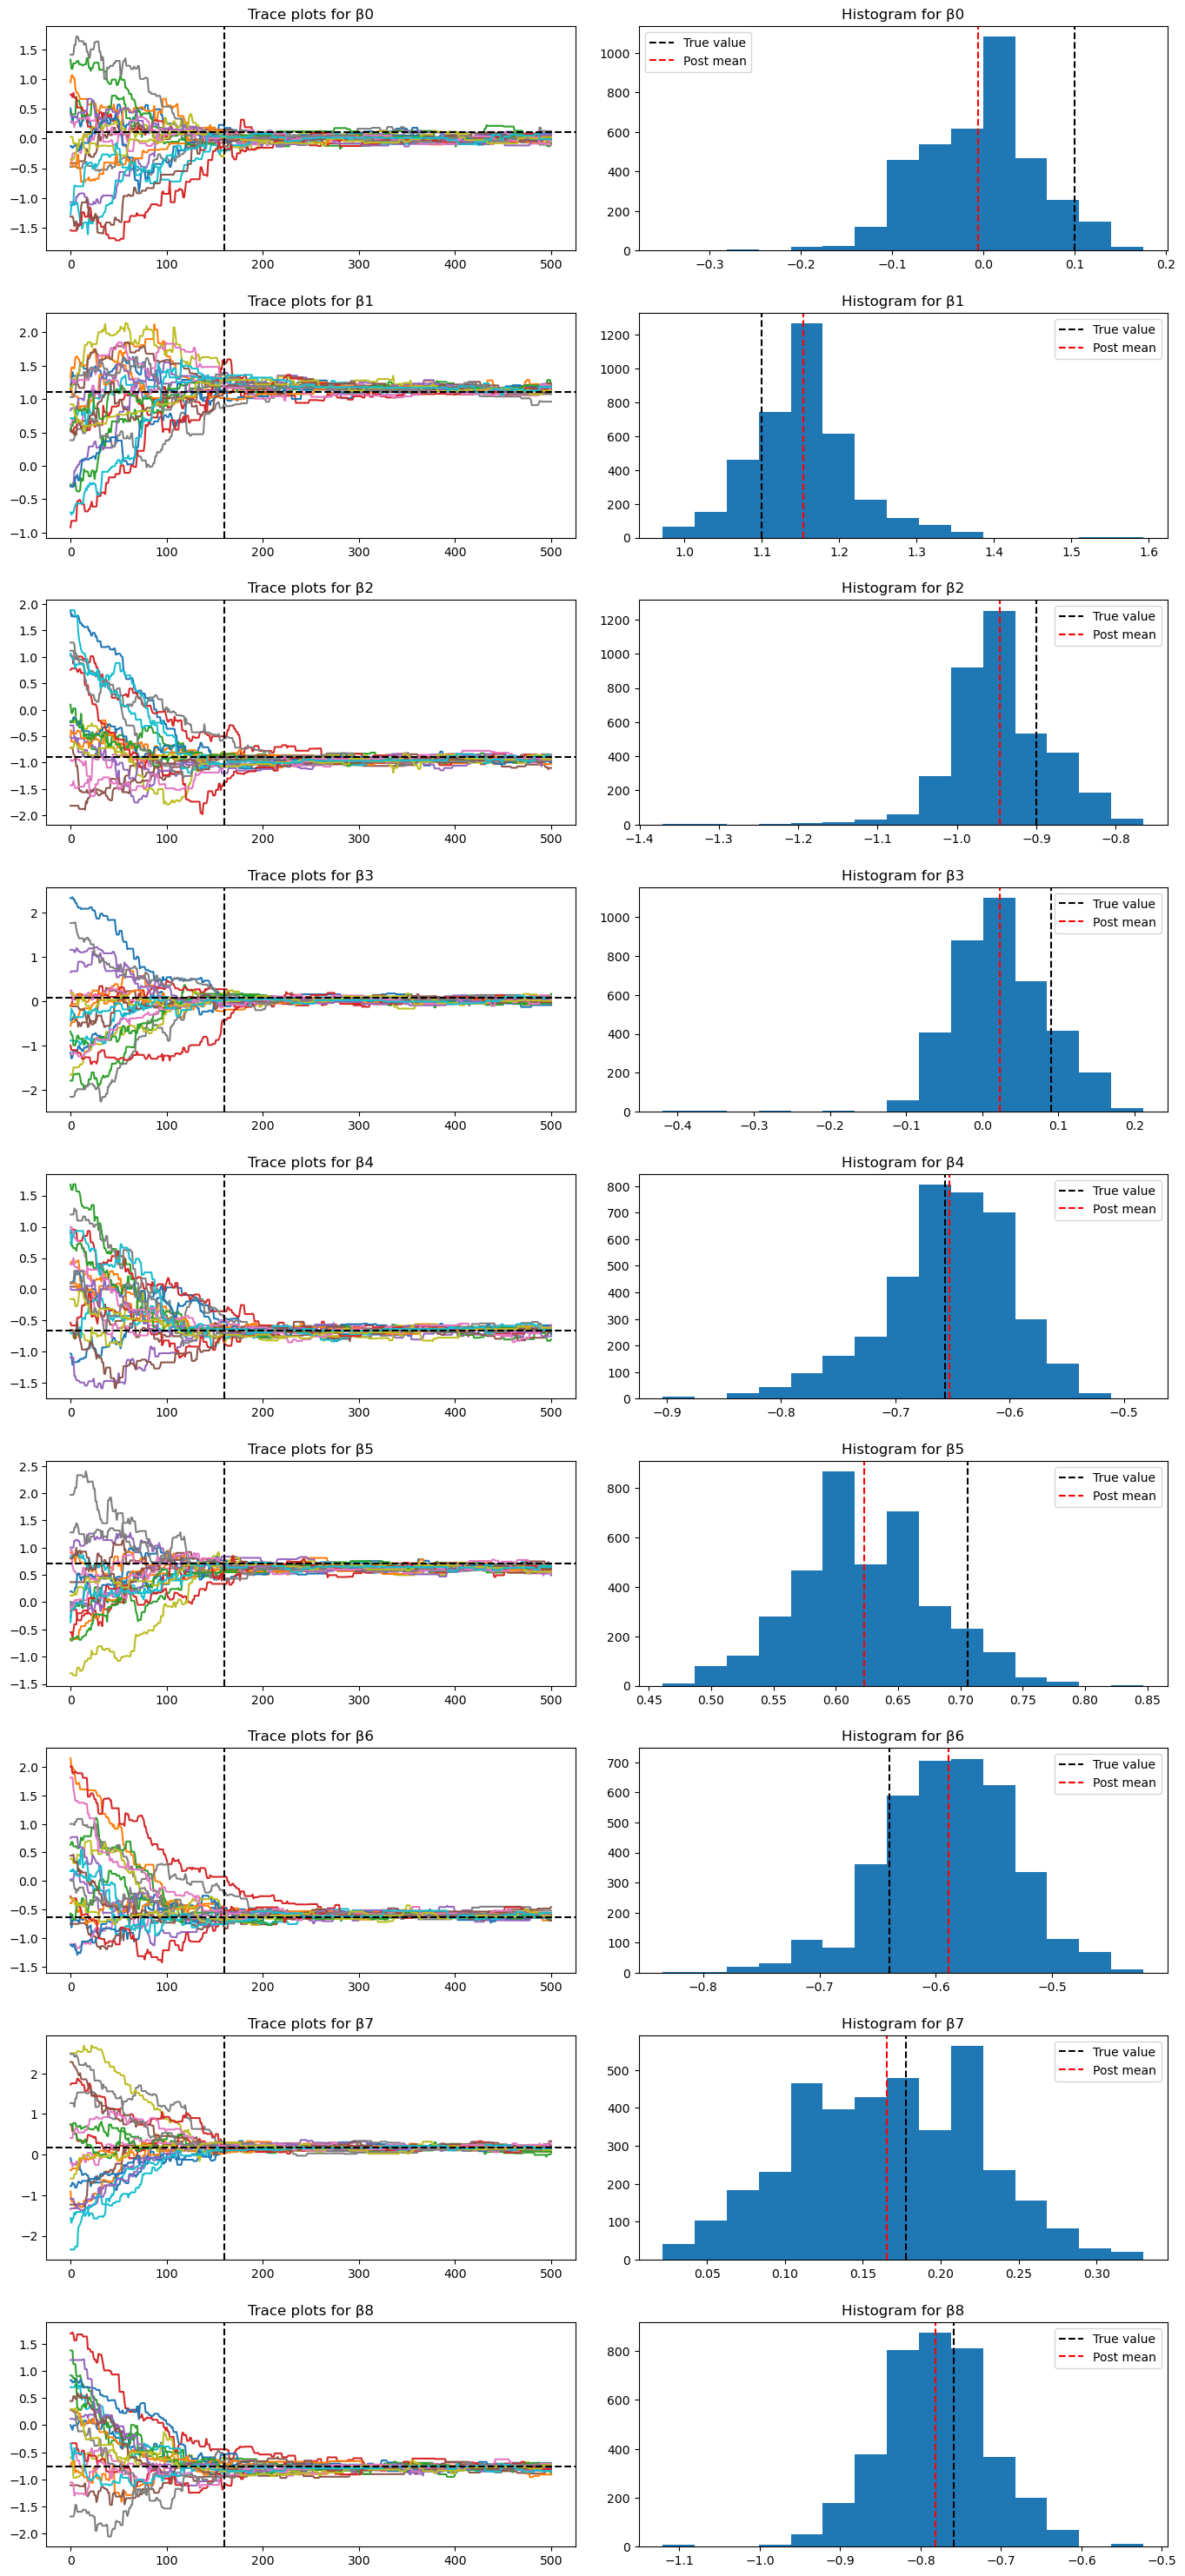

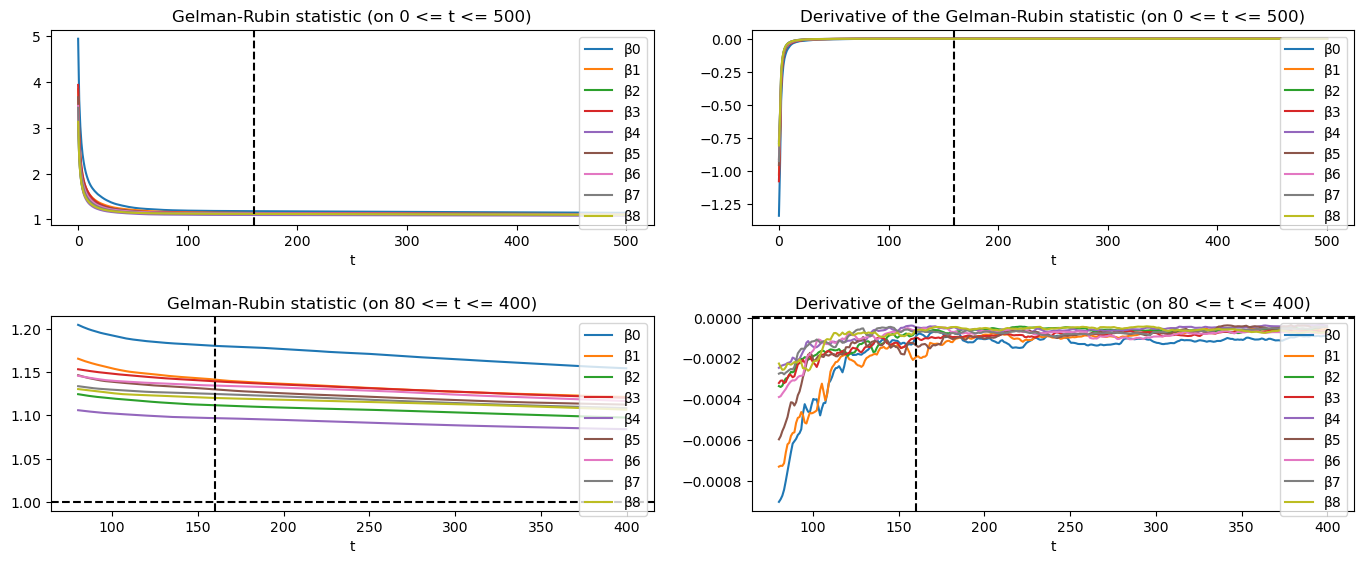

In [75]:
main_walker(N=2000,dof=9,M=20,burn_ind=160,two_proposal=True) ## 20 chains, 9 parameters, choose between two proposals

In [78]:
sum([0.024, 0.295, 0.262, 0.0039, 0.1813, 0.2781, 0.2454, 0.0714, 0.0225])

1.3836

In [79]:
sum([0.117,0.02,0.045,0.1049,0.0943,0.1219,0.1396,0.0086,0.0485])

0.6998000000000001